In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.legacy.vae import assess_vae_results

from src.functions.embryo_df_performance_metrics import *


pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
#these arefunctions that will search for the embryo_stats_csv file and then attempt to create it
def find_embryo_stats_csv(model_path):
    """
    Recursively search for the 'embryo_stats_df.csv' file starting from model_path.
    Parameters:
        model_path (str): The base path to start searching.
    Returns:
        str: The full path to the 'embryo_stats_df.csv' file if found, otherwise None.
    """
    target_file = 'embryo_stats_df.csv'
    
    for root, dirs, files in os.walk(model_path):
        if target_file in files and 'figures' in root:
            return os.path.join(root, target_file)
    
    print(f"File '{target_file}' not found under {model_path}")
    return None


def get_embryo_df_path(model_path):
    embryo_df_path = find_embryo_stats_csv(model_path)
    
    if embryo_df_path is None:
        print(f"File 'embryo_stats_df.csv' not found under {model_path}")
        print("Attempting to generate 'embryo_stats_df.csv'...")
        
        path_parts = model_path.strip(os.sep).split(os.sep)
        
        try:
            model_name = os.path.basename(model_path)
            # a couple of parameters for the model assessment script
            overwrite_flag = False # will skip if it detects the exprected output data already
            n_image_figures = 100  # make qualitative side-by-side reconstruction figures
            assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)

            # Try to find the 'embryo_stats_df.csv' again
            embryo_df_path = find_embryo_stats_csv(model_path)
            
            if embryo_df_path is None:
                print(f"Failed to generate 'embryo_stats_df.csv' under {model_path}")
        except ValueError:
            print(f"Could not parse 'model_path' to extract necessary components: {model_path}")
            embryo_df_path = None
        except ImportError:
            print("Could not import 'assess_vae_results'. Please ensure it is correctly imported.")
            embryo_df_path = None
        except Exception as e:
            print(f"An error occurred while generating 'embryo_stats_df.csv': {e}")
            embryo_df_path = None
    return embryo_df_path

def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample_wt=False,
    wt_downsample_frac=0.1,
    random_state=42
):
    # Copy the dataframe to avoid modifying the original data
    df = test_df.copy()

    # Downsample wild-type data if enabled
    if downsample_wt:
        # Identify wild-type entries (assuming 'perturbation' column indicates perturbation status)
        wt_mask = df['phenotype'] == 'wt'
        wt_df = df[wt_mask]
        perturbed_df = df[~wt_mask]

        # Get unique embryo_ids for wild-type
        unique_wt_embryos = wt_df['embryo_id'].unique()

        # Calculate the number of embryos to sample
        n_sample = max(1, int(len(unique_wt_embryos) * wt_downsample_frac))

        # Randomly sample embryo_ids
        sampled_embryos = np.random.RandomState(random_state).choice(
            unique_wt_embryos, size=n_sample, replace=False
        )

        # Filter the wild-type dataframe
        wt_df_sampled = wt_df[wt_df['embryo_id'].isin(sampled_embryos)]

        # Combine back with perturbed data
        df = pd.concat([wt_df_sampled, perturbed_df], ignore_index=True)
    
    # Prepare data for PCA
    X = df[z_mu_biological_columns].values

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)
    df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
    df_pca = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

    # Prepare color and size settings
    if perturbations is None:
        perturbations = df_pca['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
    
    # Handle embryo highlighting
    df_pca['marker_size'] = marker_size
    df_pca['opacity'] = opacity
    df_pca['color'] = df_pca['phenotype'].map(color_discrete_map)

    if highlight_embryos:
        if highlight_colors is None:
            highlight_colors = ['red'] * len(highlight_embryos)
        highlight_dict = dict(zip(highlight_embryos, highlight_colors))
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'marker_size'] = highlight_marker_size
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'color'] = df_pca['embryo_id'].map(highlight_dict)
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'opacity'] = 1.0

    if plot:
        fig = px.scatter_3d(
            df_pca,
            x='PC1',
            y='PC2',
            z='PC3',
            color='phenotype',
            symbol='phenotype',
            size='marker_size',
            opacity=opacity,
            color_discrete_map=color_discrete_map,
            title=title
        )

        if not show_legend:
            fig.update_layout(showlegend=False)

        fig.show()

    return fig  # Return the PCA-transformed dataframe for further use






/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
segment_data

10

In [2]:

# set key path parameters
root = "/net/trapnell/vol1/home/nlammers/projects/data/morphseq/" # path to top of the data directory
train_folder = "20241107_ds" # name of 'master' training folder that contains all runs
sweep_df_path = os.path.join(root, "metadata", "parameter_sweeps", "sweep01", "")

# load dataframes for each component of the sweep--I've broken it up into 6 chunks, 5 of which are currently running on the cluster (other is on workstation)
df_list = []
for block_num in range(0, 5):
    # load df
    temp_df = pd.read_csv(sweep_df_path + f"sweep01_{block_num:02}.csv")
    # keep only runs that have finished
    temp_df = temp_df.loc[temp_df["completed"]==1, :]
    # add to list
    df_list.append(temp_df)

# combine
sweep_df = pd.concat(df_list, axis=0, ignore_index=True)

# Subset the dataframe to only include completed entries
completed_df = sweep_df[sweep_df['completed'] == True].copy()

# Apply the function to generate the 'embryo_df_path' column
completed_df['embryo_df_path'] = completed_df['model_path'].apply(find_embryo_stats_csv) # change to get_embryo_df_path when you want to calc the embryo_df



File 'embryo_stats_df.csv' not found under /net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter050
File 'embryo_stats_df.csv' not found under /net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter051
File 'embryo_stats_df.csv' not found under /net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter052
File 'embryo_stats_df.csv' not found under /net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter053
File 'embryo_stats_df.csv' not found under /net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter054
File 'embryo_stats_df.csv' not found under /net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_

In [3]:
parameter_cols = [
    'metric_loss_type',
    'margin',
    'metric_weight',
    'self_target_prob',
    'time_only_flag',
    'temperature',
    'learning_rate',
    'latent_dim',
    'beta',
    'batch_size',
    'zn_frac'
]

# Group the dataframe by parameter columns
grouped = completed_df.groupby(parameter_cols)

# Initialize a list to collect new rows
new_rows = []

# Iterate over each group
for group_keys, group_df in grouped:
    holdout_flags = group_df['holdout_flag']
    # Check if both holdout_flag values 0 and 1 are present
    if set(holdout_flags) == {0, 1} and len(holdout_flags) == 2 :
        # Extract rows for holdout_flag 0 and 1
        hld_row = group_df[group_df['holdout_flag'] == 1].iloc[0]
        nohld_row = group_df[group_df['holdout_flag'] == 0].iloc[0]
        
        # Create a new row with shared parameters and separate paths
        new_row = dict(zip(parameter_cols, group_keys))
        #process_id (identifier of uniqur unique_run)
        new_row['process_id_hld'] = hld_row['process_id']
        new_row['process_id_nohld'] = nohld_row['process_id']
        #path for model that was run
        new_row['model_path_hld'] = hld_row['model_path']
        new_row['model_path_nohld'] = nohld_row['model_path']
        # path to the embryo_df from unique run
        new_row['embryo_df_path_hld'] = hld_row['embryo_df_path']
        new_row['embryo_df_path_nohld'] = nohld_row['embryo_df_path']


        new_rows.append(new_row)

# Create a new dataframe from the list of new rows
paired_models_df = pd.DataFrame(new_rows)

# Remove rows where 'embryo_df_path_hld' or 'embryo_df_path_nohld' is None
paired_models_df = paired_models_df[
    paired_models_df['embryo_df_path_hld'].notnull() &
    paired_models_df['embryo_df_path_nohld'].notnull()
]

# Ensure 'embryo_df_path_hld' and 'embryo_df_path_nohld' are not the same
duplicates = paired_models_df[paired_models_df['embryo_df_path_hld'] == paired_models_df['embryo_df_path_nohld']]
if not duplicates.empty:
    print("Duplicate embryo_df_path found in the following rows:\n", duplicates)

# Remove rows with duplicate paths
paired_models_df = paired_models_df[paired_models_df['embryo_df_path_hld'] != paired_models_df['embryo_df_path_nohld']]


# Reset the index and assign the old index to a new column called 'model_index'
paired_models_df.reset_index(inplace=True)
paired_models_df.rename(columns={"index": "model_index"}, inplace=True)

# Display the updated DataFrame
paired_models_df


model_index metric_loss_type  margin  metric_weight  self_target_prob  \
0              0          NT-Xent     0.1             10              0.25   
1              1          NT-Xent     0.1             10              0.25   
2              2          NT-Xent     0.1             10              0.50   
3              3          NT-Xent     0.1             10              0.50   
4              4          NT-Xent     0.1             10              0.50   
..           ...              ...     ...            ...               ...   
150          192          triplet     5.0             10              0.50   
151          194          triplet     5.0             10              0.75   
152          198          triplet     5.0             25              0.50   
153          201          triplet     5.0             25              0.50   
154          206          triplet     5.0             50              0.25   

     time_only_flag  temperature  learning_rate  latent_dim  beta  batch_size  \
0                 0          0.1         0.0001         100   0.1        2048   
1                 0          0.1         0.0001         100  10.0        2048   
2                 0          0.1         0.0001         100   1.0        2048   
3                 0          0.1         0.0001         100  10.0        2048   
4                 1          0.1         0.0001         100   0.1        2048   
..              ...          ...            ...         ...   ...         ...   
150               1          0.1         0.0001         100  10.0        2048   
151               0          0.1         0.0001         100   1.0        2048   
152               0          0.1         0.0001         100   0.1        2048   
153               1          0.1         0.0001         100   0.1        2048   
154               0          0.1         0.0001         100   1.0        2048   

     zn_frac  process_id_hld  process_id_nohld  \
0        0.2             417               136   
1        0.2             231               403   
2        0.2              20               311   
3        0.2             283               241   
4        0.2              12               378   
..       ...             ...               ...   
150      0.2             166               143   
151      0.2             268               336   
152      0.2             275               226   
153      0.2             230                21   
154      0.2             206                 8   

                                        model_path_hld  \
0    /net/trapnell/vol1/home/nlammers/projects/data...   
1    /net/trapnell/vol1/home/nlammers/projects/data...   
2    /net/trapnell/vol1/home/nlammers/projects/data...   
3    /net/trapnell/vol1/home/nlammers/projects/data...   
4    /net/trapnell/vol1/home/nlammers/projects/data...   
..                                                 ...   
150  /net/trapnell/vol1/home/nlammers/projects/data...   
151  /net/trapnell/vol1/home/nlammers/projects/data...   
152  /net/trapnell/vol1/home/nlammers/projects/data...   
153  /net/trapnell/vol1/home/nlammers/projects/data...   
154  /net/trapnell/vol1/home/nlammers/projects/data...   

                                      model_path_nohld  \
0    /net/trapnell/vol1/home/nlammers/projects/data...   
1    /net/trapnell/vol1/home/nlammers/projects/data...   
2    /net/trapnell/vol1/home/nlammers/projects/data...   
3    /net/trapnell/vol1/home/nlammers/projects/data...   
4    /net/trapnell/vol1/home/nlammers/projects/data...   
..                                                 ...   
150  /net/trapnell/vol1/home/nlammers/projects/data...   
151  /net/trapnell/vol1/home/nlammers/projects/data...   
152  /net/trapnell/vol1/home/nlammers/projects/data...   
153  /net/trapnell/vol1/home/nlammers/projects/data...   
154  /net/trapnell/vol1/home/nlammers/projects/data...   

                                    embryo_df_path_hld  \
0    /net/trapnell/vol1/home/nlammers/proj

In [4]:

# Dictionaries to store outputs
core_performance_metrics_dict = {}
splines_final_dict = {}
scaffold_align_metrics = []
results_dict = {}

# Loop over each row in paired_models_df
# for i in range(len(paired_models_df)):

for model_index in paired_models_df["model_index"].unique():
# for model_index in [0]:
    row = paired_models_df[paired_models_df["model_index"]==model_index]

    path_all = row["embryo_df_path_nohld"].iloc[0]
    path_hld = row["embryo_df_path_hld"].iloc[0]
    
    # Read the dataframes
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    # Identify biological Z columns
    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]
    
    # Call the function
    core_performance_metrics = produce_performance_metrics(
        df_all,
        df_hld,
        pert_comparisons,
        logreg_tol=1e-3,
        subsample_fraction=0.001,
        subsample_fraction_jaccard=0.1,
        num_bins=20,
        max_hpf=40,
        random_state=100,
        plot=False,
        k_neighbors=5
    )
    core_performance_metrics["model_index"]=model_index


    # Dictionary to store dataframes with PCA columns added
    data_dict = {}

    # Compute PCA and augment dataframes for both "all" and "hld"
    for df_label, df_raw in [("all", df_all), ("hld", df_hld)]:
        X = df_raw[z_mu_biological_columns].values
        pca = PCA(n_components=3)
        pcs = pca.fit_transform(X)

        df_raw["PCA_1"] = pcs[:,0]
        df_raw["PCA_2"] = pcs[:,1]
        df_raw["PCA_3"] = pcs[:,2]

        # Color mapping for perturbations
        perturbations = pert_comparisons
        color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
        df_raw['color'] = df_raw['phenotype'].map(color_discrete_map)

        # Store the augmented dataframe
        data_dict[df_label] = df_raw

    # Dictionary to store spline points for each dataset and perturbation
    # Key: (df_label, pert), Value: array of spline points shape (num_spline_points, 3)
    splines_dict = {}

    # Fit splines for each perturbation and dataset in a single combined loop
    for pert in pert_comparisons:
        for df_label, df in data_dict.items():
            print(f"Processing {pert} in {df_label} dataset...")

            pert_df = df[df["phenotype"] == pert].reset_index(drop=True)

            # Calculate early time point
            avg_early_timepoint = pert_df[
                (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
                (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
            ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

            # Downsampling logic
            if pert == "wt":
                pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
            else:
                pert_df_subset = pert_df.sample(frac=0.1, random_state=42)

            print(f"Subset size: {len(pert_df_subset)}")

            pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values

            # Fit the Local Principal Curve on the subset
            lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=2)
            paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint], remove_similar_end_start_points=True)

            # Extract the first path (assuming one main path)
            spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)
            splines_dict[(df_label, pert)] = spline_points

    # Convert spline data to a DataFrame
    rows = []
    for (df_label, pert), spline_points in splines_dict.items():
        num_points = len(spline_points)
        for i, point in enumerate(spline_points[::-1], start=1):
            rows.append({
                "dataset": df_label,
                "Perturbation": pert,
                "point_index": num_points - i,
                "PCA_1": point[0],
                "PCA_2": point[1],
                "PCA_3": point[2]
            })

    splines_df = pd.DataFrame(rows)

    # Alignment and scaffold metrics
    splines_dict_aligned = []
    all_combined = []
    hld_combined = []
    hld_aligned_combined = []

    for pert in pert_comparisons:
        all_points = extract_spline(splines_df, "all", pert)
        hld_points = extract_spline(splines_df, "hld", pert)

        # Perform Kabsch alignment
        R, t = quaternion_alignment(all_points, hld_points)
        hld_aligned = (hld_points @ R.T) + t

        # Compute errors
        initial_rmse = rmse(all_points, hld_points)
        aligned_rmse = rmse(all_points, hld_aligned)

        # Accumulate for scaffold comparison
        all_combined.append(all_points)
        hld_combined.append(hld_points)
        hld_aligned_combined.append(hld_aligned)

        splines_dict_aligned.append({"Perturbation": pert, "spline": hld_aligned})
        scaffold_align_metrics.append({
            "model_index": model_index,
            'Perturbation': pert,
            'Initial_RMSE': initial_rmse,
            'Aligned_RMSE': aligned_rmse
        })

    # Compute scaffold-level metrics
    all_combined = np.concatenate(all_combined, axis=0)
    hld_combined = np.concatenate(hld_combined, axis=0)
    hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

    scaffold_initial_rmse = rmse(all_combined, hld_combined)
    scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)

    scaffold_align_metrics.append({
        "model_index": model_index,
        'Perturbation': 'avg_pert',
        'Initial_RMSE': scaffold_initial_rmse,
        'Aligned_RMSE': scaffold_aligned_rmse
    })

    scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

    # Add aligned spline points to DataFrame
    for spline in splines_dict_aligned:
        for i, point in enumerate(spline["spline"]):
            rows.append({
                "dataset": "hld_aligned",
                "Perturbation": spline["Perturbation"],
                "point_index": i,
                "PCA_1": point[0],
                "PCA_2": point[1],
                "PCA_3": point[2],
            })

    #store the spline in dict
    splines_final_df = pd.DataFrame(rows)
    splines_final_dict[model_index] = splines_final_df
    
    # Process segment direction consistency
    across_seg_df, within_seg_measures = process_segment_direction(splines_final_df, model_index)
    print("Segment Direction Measures:")
    print(within_seg_measures)

    # Calculate dispersion metrics
    dispersion_metrics_df = calculate_dispersion_metrics(splines_final_df, n=5)
    combined_dispersion_df = process_dispersion_metrics(dispersion_metrics_df, model_index)
    print("Dispersion Metrics for Each Dataset:")
    print(combined_dispersion_df)

    # Store results in a dictionary
    results_dict[model_index] = {
        "across_seg_df": across_seg_df,
        "within_seg_measures": within_seg_measures,
        "dispersion_metrics": combined_dispersion_df
    }
    
    results_df = combine_results_dict(results_dict)

    scaffold_align_metrics_df_final = scaffold_align_metrics_df.merge(results_df, on=["model_index", "Perturbation"], how="left")


    core_performance_metrics = core_performance_metrics.merge(scaffold_align_metrics_df_final, on=["model_index", "Perturbation"], how="left")


    core_performance_metrics_dict[model_index] = core_performance_metrics
   

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.09251288 -4.09274043  0.7268158 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.23796164 -3.29886871  2.11299495]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.54220925 -4.30613584 -0.64339955]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.7960093  -4.16506891  0.69143141]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.24096599 -3.52734045 -2.93670947]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.6680632   0.93895584 -0.24648829]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.90583376 1.02881667 0.04992963]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.6247475   1.11310981 -0.16834803]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.84977249  1.01778514 -0.05361711]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [1.61597098 1.33269246 0.2537886 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.25420343  2.70373922  0.25645388]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.64439224 -0.77920987 -1.49643388]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.10339516 3.13686881 0.1988146 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.553748   -1.1356639  -1.63187421]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [0.89038154 3.69463943 0.83213548]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.6733045  -1.08236728  0.23143003]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.87359519 -0.95108325  0.34533308]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.56776218 -1.14837874  0.21166669]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.85679964 -0.98551804  0.1542903 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.58270103 -1.31503041 -0.11777163]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.31019858  3.94917137 -2.3876098 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.69157358  4.0559079  -2.27689453]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.05706539  3.82519115 -2.60592574]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.57608622  4.26839716 -3.22625207]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-4.7227364   4.00314759 -4.16564817]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.78271785 -0.00239115  0.81617007]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.03264496 -0.09183351  0.85857525]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.82434406  0.02107502  0.78444799]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.00376961 -0.10870197  0.80479681]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.8006185   0.00865017  1.00151848]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.56988132 -2.18374732 -1.33306239]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.78951195 -2.30179208  0.30332743]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.65428071 -2.20708959 -1.27931848]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.9711343  -2.27807267  0.40415526]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.03205684 -2.4260023  -2.00538716]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.64087219  1.09324509 -0.19694704]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.69372964  0.95641533 -0.07063218]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.63824227  1.14272532 -0.10732697]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.7004584   1.08675758 -0.04087446]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [1.62323553 1.35431494 0.30404008]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.48846848  3.86667376  1.52390414]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.14056278 -3.44472038  0.20958531]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.59739076  4.09846522 -0.53922693]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.01376225 -4.01974043 -0.66516216]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.11015613  3.53284367 -2.55164329]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.68331343  0.98987091 -0.37801525]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.45522415 -1.43974937  0.45789636]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.76239382  1.17623872 -0.54948976]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.40136627 -1.47133657  0.29092792]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.58406117  1.3636437  -0.3741106 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.09758619  4.22356267  0.37188565]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.79818109 -3.85726313 -0.14176238]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.69594196  4.3777682  -0.45981104]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.20854545 -4.00184808 -2.14241882]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.27524184  3.07044979 -3.38399179]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.50593333  2.67634045 -0.20909229]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.94333909  2.39006023 -1.05897747]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.29767353  3.03495602 -0.7604561 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.73327976  2.366089   -1.97245181]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.3378373   2.23816579 -2.16415926]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.67862953  1.38067903 -0.03887521]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.66083209  0.08296513  0.94420533]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.58616461  1.38577052 -0.18937493]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.6756729  -0.19920865  1.12890841]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.30282106  1.88697802 -0.22341846]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.96585223  5.70136073  3.18636533]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.9457619   5.38996631  2.39060194]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.63782972  6.65128202  2.7942316 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.75629064  5.42269651  2.89072905]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.3019733   5.82399491  7.03909406]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [0.80232865 3.21248257 1.79755538]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.18599454  3.58571693 -1.83578634]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.86654191 3.09121162 1.9298347 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.05670466  3.57878468 -2.38031989]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [1.08949882 2.75609251 3.44964004]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.21203101 -4.02085363  0.20562309]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.17478052 -4.30834137  0.87410886]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.85576117 -5.22507777 -1.61782989]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.03184734 -4.8991233  -1.30641667]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.03280731 -3.18087943 -6.06824258]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.94227501  0.90311958 -1.42796556]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.06838354  0.47226917 -1.29530833]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.71655129  0.53341316 -1.54761358]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.90126162  0.22980436 -1.52063245]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.3651399   0.44609463 -2.32576814]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.98547224  4.65753746  0.11516963]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.65046531  5.14341917  1.45575219]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.08526926  4.63979679  1.00962608]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.35619761  4.60698729 -0.06069008]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.71280765  4.09960935  5.06886484]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [0.11825479 3.51498751 2.30992628]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.22846722  3.12193637 -2.71128331]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.15536606 3.69382748 2.38944101]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.42014814  2.895696   -2.44601559]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [0.29605673 2.57314404 3.70389997]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.21354213  3.86191922  1.63555268]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.70550082  3.94268534 -1.32705109]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.92027306  5.11801872 -1.11567465]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.31772183  4.00738838  0.47441948]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.66864046  3.51042636 -3.22829993]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.57227527  2.61083489 -0.06373485]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.05944265  2.76900987 -0.86852547]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.70235377  2.0718427  -0.59280967]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.27375117  2.0954571  -1.77924889]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.95841667  1.59853551 -2.49232529]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.29377184 4.15298093 0.0760501 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.34700272  3.35464026 -2.39302575]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.23563221  4.53335575 -1.00856732]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.3243865   2.1775895  -3.58228295]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.8186978   3.14966561 -2.86993944]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.17359184 -2.09608053 -1.22421614]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.21676776  2.63832745 -0.55189481]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.28109467 -1.7915971  -1.37501113]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.28161505  2.91896099 -0.55573545]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.66817849 -2.66839656 -2.10017166]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.80549835 1.24825766 0.17783425]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.85799166 0.89543559 0.0707558 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.81586385  1.25029335 -0.01628393]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.82118435  1.04708202 -0.01687838]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.8439793   1.29763774 -0.38725984]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.38184098 -1.55613829 -1.42938595]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.02603972 2.58061441 0.03644081]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.55364777 -1.61612764 -1.48624295]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [1.24295924 2.69878602 0.14608056]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.07318553 -2.10607528 -2.6088843 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.13723488  4.05739479 -2.32348601]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.14182324  4.19117713 -2.06853088]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.10261659  3.82240796 -2.63598589]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.95227148  4.54373349 -1.73183872]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-4.68394375  3.93494604 -4.35068914]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.93367197  0.91242776 -0.07012096]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [2.05897584 0.05965436 0.87859544]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.98074842  0.99163006 -0.1660872 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [2.03641535 0.04865052 0.82500494]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.00922205  0.9841091  -0.43343725]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [0.16778231 3.99332593 0.81427216]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.00282329  3.40592248 -2.60806182]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.58414741 2.65844938 2.42967089]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.70071281  1.22043683 -2.87387937]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [2.10828653 1.17460281 1.54965508]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.63861779 1.12780415 0.09527965]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.7278851   0.97657523 -0.2812812 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.6480604   1.14666714 -0.04877212]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.80136235  1.01995542 -0.21214303]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.66677003  1.31233875 -0.49282281]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [2.8091207  1.21934738 0.83992438]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.02776238  2.50785579 -1.18219661]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [2.86354774 1.44760893 1.32524246]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.71841032  2.21489556 -2.07021405]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [1.78836355 1.33950064 1.53491291]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.70778695  0.95637628 -0.39801513]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.59865625 -1.40348425  0.28979435]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.80620136  1.04996479 -0.58433902]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.5576589  -1.4243324   0.14493194]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.63484395  1.32534617 -0.39934452]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.49550797 -4.18978775  1.15826592]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.71136093 -3.3003789   2.42719774]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.28134481 -4.27194656 -1.21844317]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.07914034 -4.04314465  0.34119615]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.45389426 -2.34910273 -3.83453864]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.43344609  2.76178771 -0.17856652]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.93362518  2.34196832 -1.23769175]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.17916641  3.09019703 -1.26208225]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.80620278  1.59015452 -2.12169794]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.17527209  2.53110822 -1.79464412]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.0274523   5.63681432  2.09478361]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.64566599  5.27004883 -1.94522247]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.1118405   6.33833491  2.11799507]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.93174875  5.80356541 -1.80200987]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-5.89906998  5.17913931  5.80351415]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.1799225   3.3837385  -1.99716688]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.33823081  3.46077783 -1.7717012 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.34491398  3.37731825 -1.74215388]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.54352714  3.24445986 -2.03198127]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.02804966  3.19117896 -2.95467066]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.91017422  1.31257174 -0.28962112]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.95455775  1.30375507 -0.18264952]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.80373037  1.3480505  -0.34536548]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.98147499  1.31624634 -0.24350715]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.75529181  1.79434137 -0.16659097]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.98687934  3.78080161  1.73618884]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.98797103 -2.93640531  2.40296961]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.04971499  4.27650337 -0.01610206]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.17913537 -3.40599337  0.74710379]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.58614047  2.30158336 -1.48768162]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.70514208  1.11262456 -0.30974267]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.79062247  0.26717781  1.24707545]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.50341207  1.23857297 -0.52612746]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.75504257 -0.04537429  1.18915842]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.32814032  1.41461395 -0.56331552]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.18419752 -3.92016771  0.09202051]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.76140762 -3.93466752 -0.52100022]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.06169392 -4.82052459 -1.39771511]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.44102021 -4.85244459  1.26940349]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.9734504  -5.75467137 -4.3464005 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.40097001  1.91566415 -1.92820361]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.37578472  2.23877265 -1.58013326]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.13986914  1.91483889 -2.39005656]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.38452284  2.08138542 -2.47805398]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.15317382  0.23105552 -3.38071706]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.74257125  0.77580902 -1.56216388]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.80494719  0.59050094 -1.33368636]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.81089017  0.34040339 -1.7346365 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.85997018  0.2121301  -1.44655289]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.32409522  0.29076158 -2.25389331]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [0.276044   3.53360842 2.47286504]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.4720917   2.92760934 -2.68299039]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.71361501 3.50415892 2.62256508]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.65726192  2.83304574 -2.44119101]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [0.13673439 1.99568847 4.7904284 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.82826     2.01395902  0.29178095]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.84478335  1.37304452 -0.48711867]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.76318052  2.15525361  0.39303457]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.93850936  1.37320851 -0.44693096]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.16197083  2.62353182  1.29071266]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.44840658  3.32893596  0.5939336 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.63917208  3.80291994  1.81977323]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.85737161  3.68644375  0.07907776]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.13167762  4.58762061 -0.54451298]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.45711044  2.75930897 -4.4259687 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.87355555 -2.31788276 -0.61609974]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.55818032  2.3586887  -0.60798997]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.16355187 -2.01863483 -1.13134572]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.16096416  1.82757839 -1.71294504]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.30968092  0.06639291 -2.71233795]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.30446964 4.01546626 0.57862415]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.36798317 -4.3044173   0.6414893 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.12255065  4.12659018 -1.51797695]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.15820935 -4.62106058 -0.45766922]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.06641463  3.22990808 -3.05994888]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.85171289  2.50389931 -0.1128772 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.13703093 -2.08777898 -0.44920566]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.63935445  2.77028761 -0.30233032]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.18136159 -2.33828519 -0.76126232]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.01459713  3.25790617 -0.76983065]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.67873253 -0.87756674 -0.31966123]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.75567954  0.98609095 -0.19969589]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.65638376 -1.092731   -0.20490367]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.72581542  1.03711508 -0.19904865]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.6623191  -1.28629603  0.08328805]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.12971455 -4.01707362  1.39387463]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.21838327  3.6953245  -0.75449285]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.87351358 -3.69952422 -0.27257149]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.64663053  3.01149093 -2.49085743]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.31048866 -3.27569987 -2.27857581]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.24155601 -2.30236277 -1.14824739]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.42571128 -1.81151419 -0.03970087]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.51791372 -2.61154644 -1.14839658]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.39912693 -2.04154516 -0.04022457]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.77847877 -2.62531655 -1.70328415]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.65145858 1.13687738 0.1022727 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.73374025  0.97559154 -0.25135207]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.65305383  1.13767978 -0.04708649]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.81298417  1.0145638  -0.19126414]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.70038598  1.24199804 -0.3905875 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.88659084 -2.88970622 -1.09620379]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.92155157  3.01287491 -0.63047921]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.5953033  -2.66946277 -1.95359496]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.61738784  2.89771986 -1.33723256]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.31245165 -2.30571554 -2.1835099 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.69443249  0.988685   -0.37520197]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.80231759  0.13889769  1.03677461]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.68900754  1.03352954 -0.54426416]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.82680452 -0.06616951  1.20096091]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.5382682   1.33507761 -0.47214803]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.36973274  4.09506777  0.74085753]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.04932998 -4.22704921  1.87528096]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.94161973  4.02078817 -0.49003443]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.17499587 -4.4301483  -0.30736977]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.15197756  3.04601053 -3.12918822]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.70286438  2.5684728  -0.14489133]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.38628591  2.49471219 -0.79295456]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.54615786  3.16357993 -0.88327568]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.63492494  2.4399941  -1.58156185]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.20437141  2.50606897 -2.09568615]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.54985914  1.26175596 -0.21891303]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.57367338 1.43253068 0.36893994]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.47485709  1.31891912 -0.49323577]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [1.75733299 1.41541554 0.10511614]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.33711316  1.49539438 -0.64546182]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.69338099  5.60382019  2.16730041]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.49822634  5.40719519 -1.58348458]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.76520199  5.2903424   1.98470641]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.59210184  5.53271255 -1.68941537]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-6.55164188  5.09564016  5.8806645 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.82168643  1.29012443 -0.26144278]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.99630838  1.3154439  -0.20895961]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.83927206  1.28596941 -0.29201842]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.04486115  1.44040819 -0.25376278]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.04896693 -1.0109884  -0.92270018]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.11205387  2.59369508 -1.15925953]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.7195237  -0.74212653 -1.66099832]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.11020685  2.12706477 -1.6341736 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.95880528  0.00462328 -2.56147141]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.675834    1.1841784  -0.38652903]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.76233645  1.42794905 -0.06912866]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.58739536  1.3623642  -0.56835149]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.74215411  1.32847432 -0.31447979]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.29316627  1.51098198 -0.43247219]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.19195592  0.10789195 -0.40691177]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.09142281  0.48366223 -1.27209693]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.19063427  0.05197851 -0.97445202]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.89491741  0.20421788 -1.50329288]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.96934187 -0.51020821 -0.64094762]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.23080265  4.30111673  0.18020801]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.12321768  5.0558186   1.58805678]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.15127422  4.56703615 -0.61440271]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.10065547  5.02522634 -0.43164225]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.06181599  4.26007026 -5.08365402]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.95702147  1.03924324 -0.65932128]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.76951613  1.13909611  1.3465403 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.00553128  1.20161037 -0.74285054]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.86735925  0.6553896   1.52865182]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.64973178  1.44043901 -0.50209158]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.54920605  6.35137938  1.18860023]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.08180227  6.37145221  0.02439549]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.69979066  5.84492803  0.9231429 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.87721075  6.90072799 -0.28544303]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.93511558  7.42517693  7.88853691]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.15923104 -4.18143753 -1.35421929]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.20739052 -4.29784772  0.23303524]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.2129801  -3.94903908 -2.15324943]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.02612834 -4.54881626 -1.10033789]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.80456826 -2.47894327 -4.7273725 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.78918988 -0.93241292 -0.36727832]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.78016516  0.97180293 -0.19513543]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.66000568 -1.07289125 -0.20701927]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.76599061  1.06231283 -0.2435353 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.65816201 -1.32186887  0.16369154]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.1042729   3.52977983 -0.1685449 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.59246648 -3.46025958  0.43822417]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.16822759  3.68870061 -1.25746639]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.18574959 -3.86532171 -1.56487563]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.53357087  2.38023127 -2.84999055]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.42001025  2.8392704   0.5985994 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.72074685  2.48878525 -0.0531701 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.08191954  3.07280847  0.39580188]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.55924172  2.58918421 -0.04554125]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [0.57181772 3.39028682 1.13749714]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.78158265e+00  1.04831789e-03  8.16088554e-01]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.93040105 1.05519915 0.02748315]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.82611734  0.02061047  0.79780126]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [2.01570983 0.95915152 0.022776  ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.80770107  0.01878605  1.00050914]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.4632198   2.39548832  2.38504515]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.70825037  2.23602653 -2.54415524]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.3858434   0.52305152  2.86970465]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.86884158  0.95609369 -3.00157216]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.87358639  0.3061236   2.08535962]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.80504291 -2.87213901 -0.94464024]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.94146051 -2.18029106 -0.12695374]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.85748918 -2.89816276 -1.04153374]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.95071789 -2.4612336  -0.18026023]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.20189919 -2.96428847 -1.67889991]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.536584    4.17170577  0.66289445]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.45942604 -4.60490988  2.21345454]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.96665495  4.33059371 -1.09578166]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.46973273 -5.19463639  0.31909355]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.08180738  3.63325722 -3.47260753]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.6436001  -4.28839034  0.99641708]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.88190427 -3.03653941 -0.13480273]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.66347412 -4.38020015 -1.29629023]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.14539878 -4.18734768 -2.40360448]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.50541263 -2.39082886 -3.68668797]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.48580026  1.30228435 -0.219648  ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.55665554 1.46605017 0.21678219]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.44901609  1.36745556 -0.4709297 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [1.58884653 1.45768973 0.06704524]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.27355182  1.53813339 -0.67119515]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [0.49335073 3.25456075 1.94016094]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.72654538  3.53545178 -1.97270555]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.39409951 3.2715285  1.99014233]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.66662442  3.44032974 -2.24960275]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [0.94709971 2.9862124  3.37384438]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.02527948 -2.07809229 -0.80456336]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.14343241  2.50001635 -1.23643819]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.58734326 -1.99062796 -1.55238924]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.05361464  2.02499557 -2.1308047 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.10422151 -1.33203422 -2.18629426]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.72053988  1.10632497 -0.30845264]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.76899915  0.35316477  1.1479763 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.63854839  1.27971269 -0.59198503]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.75270741 -0.0047228   1.18750787]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.34749307  1.45178193 -0.52561471]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.19738676 -4.69881671  0.56059514]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.10737797 -4.43673933  0.63407765]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.36097536 -5.37392136 -1.25148823]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.94853097 -5.17002859 -1.53968359]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.30151463 -4.48554386 -4.82164059]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.25729913  1.63406249  2.59585262]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.3579167   2.75351219 -1.63674948]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.17184215 1.18353521 3.48602033]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.34998923  2.39698959 -2.51265323]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.50237006 -0.48686469  3.97797763]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.40374066  0.30972047 -0.52186554]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.08393938  0.47348565 -1.25513332]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.22126788  0.07819307 -0.98694228]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.90136574  0.28448049 -1.51924233]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.93521779 -0.42978898 -0.73317911]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.97198037  4.48935878 -0.34781998]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.06320163 -4.69721777  0.02236298]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.09231897  4.57583895 -0.92926764]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.75581897 -5.53693867 -1.86268103]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.77402072  3.7652381  -5.53178351]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [0.81240616 3.77755905 2.82920394]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.28042356  2.19511589 -2.53801358]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [0.685389   3.54806904 2.46995654]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.1080097   2.64746873 -2.15971632]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [0.45648071 2.41943706 4.95825595]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.73423356 -1.8447918   1.34925374]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.47047001 -2.31202093 -1.23661401]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.83567759 -2.2641204   1.59852066]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.73797858 -2.60094793 -1.28289415]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.86491001 -2.62253304  1.85401664]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.37431517 -1.26416715 -0.03547952]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.26813549  1.88587867 -0.34068332]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.48224904 -1.34754054 -0.28854787]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.04243732  1.94814754 -0.82070146]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.71409355 -1.27390868 -0.06230892]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.63032433 -0.06087388  0.33173419]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.65408025 -0.2627481  -0.80657399]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.76590176 -0.06591674  0.38114184]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.76674764 -0.20214142 -1.03331919]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.72737278 -0.05416715  0.59178271]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.42910791 -2.0590024  -1.32256175]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.74975094 -2.07621293 -1.31540326]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.25516052 -2.28784582 -1.5516686 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.67408032 -2.40423088 -2.01722395]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.46567683 -2.42949996 -1.53669173]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.82797413  0.06979507 -0.09090348]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.65063681 -0.01112907  0.63869988]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.83377507 -0.01836017 -0.34585477]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.81659969 -0.05171249  0.6044251 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.83370592 -0.05485652 -0.4757022 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.5431191   0.77276542 -0.1021491 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.21685799 -1.16595423 -0.11441162]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.4961896   0.83895051 -0.0613817 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.26148889 -1.04451161 -0.1729729 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.33666525  0.94550482 -0.02257852]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.46302636 -1.34814153 -1.58014248]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.35630585 -2.09481343  1.6152657 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.35968123 -1.30745844 -1.71827642]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.54991506 -2.24559471  2.15938669]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.4532108  -1.83043245 -1.75051578]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.30225882 -2.01184297 -1.52993591]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.07081813 -2.19362055 -1.26157358]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.35487227 -2.50154078 -1.82809678]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.12659617 -2.61221354 -1.36491365]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.24727364 -3.19345321 -2.01397448]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.08150469 -2.00598713 -1.64819477]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.75013059 -2.24831825 -1.30003657]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.07973535 -2.34711977 -2.07073291]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.98350314 -2.65950638 -1.63706966]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.28253898 -2.81240714 -1.87214726]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.96597748 -0.41281488 -0.90682679]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.65401114 1.34353284 0.54349825]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.18615511 -0.61606403 -1.15234506]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [1.6751821  1.6786608  0.80307471]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.42536622 -0.62662045 -1.23639703]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.83084182 -0.09789747  0.4772008 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.7287168  -0.00928639  0.63089859]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.95739003 -0.04197455  0.66919587]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.8070502  -0.00325744  0.62279535]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.78956199 -0.02036085  0.87544841]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.0265618   2.56191901 -1.09715234]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.72002693 -2.14895893  0.94580214]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.00758385  2.97245739 -1.62916349]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.74124009 -2.29055145  1.22954649]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.29630452  3.52735303 -1.18388159]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.85961133 -0.92235271 -0.93812458]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.50147598 -1.40808817 -0.33723945]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.87587454 -0.85106746 -1.06457484]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.76663917 -1.44356416 -0.49552446]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.25865638 -1.12279013 -0.43962184]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.75637348  0.13190603 -0.16250737]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 0.79801134 -1.15202016 -0.06739916]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.8388427   0.056091   -0.13402657]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 0.89426421 -1.40480282 -0.22365154]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.7138113   0.05213253 -0.32893818]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.78635588 -1.82071061 -1.69424256]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.74302369 -1.79898829 -1.81018255]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.69455195 -1.90789378 -2.14013103]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.79978543 -1.85221129 -2.12815572]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.15453458 -2.23070839 -2.16706778]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.04426591 -1.63585172 -0.4641612 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.62833495 -1.17997997 -0.47852722]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.88191756 -1.57722337 -0.69679175]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.49854522 -1.12066297 -0.52516944]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.15495497 -1.96226431  0.02179856]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.99069258 -0.02153418 -0.16412607]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.62984978 -0.2229245   0.60965486]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.07292363e+00  1.72421545e-03 -8.67621417e-02]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.7283504  -0.26796265  0.64655876]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.97731646 -0.0175594   0.08018677]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset.

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.05037037 -2.47235042 -1.4499359 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.3010577   2.98412193 -1.92391535]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.10127103 -2.72092518 -1.74745654]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.08138436  3.39797676 -1.65806186]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.78241146 -3.79413806 -2.17036955]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.45742023 -0.031817    0.71090968]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.82497093  1.31736774 -0.07196536]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.63642107 -0.03985008  0.75661839]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.93777664  1.42052621 -0.21040235]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.58527572 -0.00934121  0.85972453]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.79637703 -2.47947993 -1.65096591]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.59347721 -2.53976154  1.38005284]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.92298236 -2.94168567 -1.9858337 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-2.74496665 -2.77144413  1.83585586]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-2.53367844 -3.76322368 -2.32014739]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.68176878  0.07964056  0.05677851]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.74070168  0.47757322 -0.1092157 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.71234417  0.01306175 -0.10868488]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.84146595  0.52302398 -0.00324405]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.67868464 -0.02115486 -0.40098182]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.66209931  0.13302002 -1.28719003]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.14422658e+00  1.23194173e+00  2.06681449e-04]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.64726707  0.02666732 -1.50892454]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.12351679  1.26391531 -0.07347355]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.61206601  0.03531628 -1.43823943]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset.

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.90005608 -5.16965459 -1.99534394]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 6.53638262  4.04493417 -2.29153022]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.78076002 -5.60426261 -2.52946276]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 6.61265046  4.58823632 -2.71501952]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 4.9570492  -6.55639608 -3.09233166]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.08453614 -1.84984565 -0.0231324 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.69473449 -1.80700833 -0.1315075 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.24705637 -1.90004023 -0.06696556]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.72813077 -1.76567661 -0.25359253]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.00203186 -2.11170707 -0.07333813]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.64896069 -0.06737612  0.36246961]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.58746138 -0.00480657 -0.55013279]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.78174487 -0.05616336  0.41812361]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.7840645  -0.00367195 -0.62755883]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.72586654 -0.07954101  0.64425474]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.01964758 -0.88800349 -1.20657867]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.40748498 1.86537633 0.01782193]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.02558808 -0.84123282 -1.68642501]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.82511308  1.92910846 -0.26160372]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.21276127 -0.86364825 -1.59725052]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 6.01690288 -5.5179386  -1.76434339]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 6.95393885 -4.21908614 -2.15507401]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.97590395 -5.91112201 -2.16645469]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 7.03801358 -4.89939624 -2.76157898]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 5.30775164 -7.17510072 -2.52163767]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.45485157 -1.27510893 -0.77982458]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.55166306  1.63893594  0.29201313]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.50101757 -1.52411151 -1.20143998]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.72888225  1.85656964  0.15753719]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.60174453 -2.01176838 -0.76230878]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.0147193  -4.40312605 -2.39745014]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.26604057 -4.29066969 -2.64286245]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.17520642 -4.55228166 -2.72280438]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.1359832  -4.64803189 -3.04113868]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 4.78520785 -5.45532488 -3.35860098]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.10650705 -1.27272091  0.18225272]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.60929751 -1.62908931  0.18183324]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.12885527 -1.22200319  0.1714347 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.85669008 -1.63909716  0.38495277]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.16358002 -1.66529924  0.25462517]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.61017141  1.44844857 -0.63650347]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [3.01826249 1.75097446 0.83678245]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.83666687  1.43604915 -0.59805702]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [2.85073693 1.56496317 0.75288687]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 3.15733068  1.77588806 -0.68503206]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 4.64860953 -6.74239449  2.90518943]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [2.75024886 7.37449667 3.06519941]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 4.12159065 -6.88227898  3.79112771]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [2.58749421 8.18815044 3.57203616]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.24819522 -7.36087425  4.68430761]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.98973049 -1.30629206 -0.88210946]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.5095571  -1.80824153  0.87817904]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 3.4346578  -1.45560029 -1.28553029]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.58814259 -1.81779415  1.12274209]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 3.59760918 -1.250014   -1.14801786]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.84081612  8.13561487 -3.55131847]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.44380232 -7.37360523 -4.1558816 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-4.15436386  8.54987954 -4.67032548]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 4.92853778 -8.20709507 -4.72150019]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.88560937  9.03871862 -7.12888542]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.83328544 -1.21423416 -0.78089632]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [2.88702347 1.58583929 0.82012806]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.90123744 -1.48605575 -1.18735854]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [3.12067254 1.90607122 0.96246162]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 3.2556564  -1.69468684 -0.9618966 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest poi

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.76588282 -0.08067219  0.44582792]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.63202489 -0.44360246 -0.35441212]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.78566478 -0.15334652  0.49210854]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.673134   -0.3547036  -0.39034986]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.74526787 -0.02661756  0.56403569]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.7057349  -2.00065111 -0.90518397]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.74152781  1.71540434 -0.4547356 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.80405906 -2.02172108 -1.13126838]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.85675058  1.51104753 -0.68067609]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.88822105 -2.55189633 -0.96472893]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.87576934  9.44027249 -2.22818469]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 4.54498723 -8.32376408 -2.18146096]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-3.02260845  9.32117386 -2.75183646]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 4.96249336 -7.81141419 -3.72149782]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.76618679  8.71017583 -2.59986334]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.64281082  3.5694723  -1.15014824]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 6.04541002  3.40061206 -1.22130891]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.92375188  3.93711652 -1.03119779]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 6.29767328  3.91140635 -1.36385566]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 5.48016491  5.2496957  -0.97691517]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.88123556  0.05199096 -0.23602206]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.37150926 1.23790081 0.00567721]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.95660423  0.02296823 -0.3045085 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.34185135  1.35625571 -0.21791373]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.92060226 -0.03616431 -0.19251417]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.23977266 -6.23809106  4.03775073]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.2769128   8.65849704 -3.07917962]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.62668139 -5.69293507  4.27420282]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.31844234  8.0550874  -3.65004095]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.12479591 -6.73438249  6.33736443]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.56546803  3.58820981 -1.67716645]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.59288192 -3.65635707 -1.22488744]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.33121324  3.76684487 -2.14377072]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.57632377 -4.10652284 -1.90353689]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 4.74228314  4.80124551 -2.36602686]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.82569354  0.11847415 -0.32523384]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.68628764  0.40793355 -0.11232863]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.91046281 -0.01514976 -0.5149763 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.74038007  0.4139214  -0.02130764]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.79226705 -0.04248252 -0.85207033]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 6.0791662  -3.51708024 -0.79263921]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.85385542  3.41443057 -1.09990066]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 6.09520407 -4.31589568 -0.90218281]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 6.11545044  3.76314735 -1.17971791]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 5.57123385 -5.21503636 -1.51530128]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.87198574  0.07955173 -0.44915624]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.7421311   0.49383704 -0.09047276]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.0409325  -0.02770319 -0.61926586]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [1.81256041 0.62556605 0.04821371]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.93693522 -0.01538679 -0.75174224]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 3.68042115 -6.60799612  2.41746064]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.43311875 -7.13952841 -0.93002434]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 3.5849143  -7.07137147  2.95191046]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.37937555 -6.55995037 -2.02935196]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.01169737 -6.82855396  3.96436507]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.82702534  0.05309516 -0.52294831]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.79892772 -0.02344779  0.50259082]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.04217344 -0.05819992 -0.72578617]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.92244629 -0.08601512  0.5325179 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.94687212 -0.03085764 -0.85212967]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 9.61857659  7.16178637 -2.05692231]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [10.38802698  5.60500748 -2.42290036]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 9.67762518  7.80190636 -2.33926842]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [10.56635869  5.95579389 -2.79330123]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 8.40864771  9.02824545 -3.61075454]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 9.00362863  6.81351973 -2.85516243]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.60502339  7.25068459 -3.07728589]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.61104027  7.29917748 -3.01251862]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.46197462  7.77516555 -4.24888258]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 7.61537265  8.9670636  -4.27311967]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 9.94269817 -7.63896754 -1.63078728]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [10.27581714 -6.83427249 -1.94562911]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [10.09424069 -7.89554666 -2.36947499]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 9.71338897 -7.07995801 -2.40877373]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 8.65060505 -9.97038483 -2.77314608]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.1771178  -6.73177938 -2.72227133]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.33438223 -6.47738856 -3.57925087]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.00902763 -7.08849235 -3.45606096]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.54644597 -7.09139755 -3.9347526 ]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 6.55456385 -7.87557296 -4.46443708]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.62232085 1.38724614 0.20958326]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.28642208 -1.86934552  0.40070263]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [1.99774678 1.37857872 0.12624437]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.25918737 -1.88075555  0.42225191]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [1.97076975 1.73439013 0.44421651]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point:

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-5.69314066 11.84990602 -4.27512749]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 6.0338319  11.40110447 -4.47268205]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-5.77910088 11.73341874 -4.22506117]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 5.43718558 11.75722899 -4.39899729]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-0.76969601 12.77270804 -4.48655001]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.64325257 -1.73980996 -0.88656532]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.71825319 -1.87791057 -0.44740731]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.64700948 -1.79146526 -1.29482482]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 3.0163015  -1.9119031  -0.53264717]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.87987986 -2.33994161 -1.37679403]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 6.48711696 -9.49074814 -3.0963897 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 2.85310935 12.49309111 -4.7985355 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 6.59245423 -9.69153844 -3.79104239]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.98780689 12.51308721 -6.36596405]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.8674643  -9.51940087 -3.89597179]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.83098658  0.09298901 -0.23518672]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.71022481 -0.05145843  0.70420789]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.91167535  0.02391617 -0.4185909 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.89980574 -0.03922237  0.69581938]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.8270103  -0.06888726 -0.65183581]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ -6.69452061 -10.43935121   6.27434907]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ -9.03181739 -10.63026277  -6.64968164]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ -6.48792481 -10.72705049   6.75807042]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ -8.14750614 -10.77290142  -6.76291728]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ -1.29497937 -11.68428172  12.85415586]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in datas

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 5.139992   -8.33784292 -4.80715389]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 4.48021264 -9.00958662 -5.03816747]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 4.9357915  -9.20735871 -5.35800298]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 4.80600867 -9.48429945 -5.60977693]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 0.7491557  -8.55999028 -5.54582274]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-3.80212199 12.85100097 -5.70317562]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.82509661  9.99443503 -3.91787797]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-4.49209797 13.82527973 -5.16199283]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.16360148 10.59289771 -5.32810454]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 2.9562559  13.49183532 -7.53458864]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 7.86014239  4.2625505  -0.97059561]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.7303879   4.79421434 -0.72181915]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.44751384  4.77614605 -1.17673647]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.80209066  4.92503889 -0.71423931]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 8.2362475   6.93680555 -0.93262209]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 7.70551009  4.51040052 -1.28852009]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.05869315  4.75236401 -1.12163656]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.31583677  4.97712689 -1.6229706 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.44264414  5.14046104 -1.57500741]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 7.94684488  6.97550939 -1.54466655]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.69826794 -0.01373995  0.48005517]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.77114487 -0.0354834   0.74728592]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.90011059  0.05350632  0.56901511]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.94951236 -0.17976556  0.68466908]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.81656662  0.00186487  0.70854724]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 3.02830443 13.98192747  7.96846807]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-11.02772377   9.93100217   8.40456155]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.3882132  14.28261411  8.39353519]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-10.71452288  10.29052892   9.16337058]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-4.43552774 12.9476028  15.86903475]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.41275802  4.05990257 -0.56734153]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.09131616  4.62290338 -0.64160693]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.80652888  4.4061953  -0.77955259]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.47367537  5.31994299 -0.77208385]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 8.62123548  6.29538238 -0.96280133]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [18.37019855  9.17703656 -0.78729105]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [18.95794549 10.32285811 -1.13641696]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [18.19311988 10.05109012 -0.92426299]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [19.28590083 10.72926414 -1.36189894]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [18.78544491 13.46913643 -1.13732376]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [17.77079838 10.1128456  -1.4925295 ]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [18.66819824 10.24730917 -1.44805521]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [18.38265871 11.12779986 -1.54975153]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [18.54331741 11.06642807 -2.00330411]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [18.15490961 14.12775903 -2.49275761]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.85078133 -0.0715164  -0.13848909]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.77100601 0.03905882 0.64704387]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.80852674e+00 -3.58219986e-04 -2.12252350e-01]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [1.90432919 0.01840469 0.75502323]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.84946023  0.03202651 -0.37179249]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.26071889 -2.00601798 -0.56039463]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-0.73082145  1.61384025 -0.17202204]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.09241658 -2.00743027 -0.47781891]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-0.61577015  1.89976055  0.12697334]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.19540341 -2.48061074 -0.52637754]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.73080005 -0.051227    0.03714919]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.23790416  0.08861535 -0.8691016 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.82727135  0.01207734 -0.03558453]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.41363137  0.1068123  -0.92821294]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-1.64919549  0.0178042   0.0914008 ]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.49873856 -1.61172572 -0.56612338]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [1.95802235 1.54719718 0.0777263 ]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.31091677 -1.5824425  -0.93847443]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.87707096  1.30962145 -0.06836753]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.4713452  -2.00073917 -0.67197257]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest 

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [17.21179232 15.70161529 -4.61636921]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 15.0156224  -17.54891547  -7.10301703]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [16.34499073 16.60322985 -4.99802589]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 14.85354152 -18.08739131  -6.76986516]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [13.5935446  20.45673486 -8.00537033]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-17.29447252  16.74311652   6.97882379]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [17.75287743 15.88451327 -7.59069171]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-17.22474147  16.68560609   7.71373491]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [17.47062578 15.70348062 -8.50396195]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-12.96616856  19.90654272  14.41641404]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Us

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/2822913627.py:19: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:131: SettingWithCopyWarning: 
A value is trying to be set o

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 7.92473852  4.45533195 -0.91869174]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 8.61794992  4.42676456 -0.42145055]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.54942621  4.68563063 -1.35209348]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 8.64434015  4.91820053 -0.87309575]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 8.36513492  6.78570629 -1.14046953]
Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using close

In [5]:
# Combine all DataFrames, adding the key as 'model_index'
core_performance_metrics_df = pd.concat(
    [df.assign(model_index=key) for key, df in core_performance_metrics_dict.items()],
    ignore_index=True
)
core_performance_metrics_df = core_performance_metrics_df[['model_index'] + [col for col in core_performance_metrics_df.columns if col != 'model_index']]


splines_final_df = pd.concat(
    [df.assign(model_index=key) for key, df in splines_final_dict.items()],
    ignore_index=True
)

splines_final_df = splines_final_df[['model_index'] + [col for col in splines_final_df.columns if col != 'model_index']]


In [7]:
# Define the save path
# Your personal directory path
paired_models_and_metrics_df = pd.merge(core_performance_metrics_df, paired_models_df, on="model_index")

personal_dir_path = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241216"

# Create the main results directory
results_path = os.path.join(personal_dir_path, "sweep_analysis")
os.makedirs(results_path, exist_ok=True)

paired_models_and_metrics_df.to_csv(os.path.join(results_path, "paired_models_and_metrics_df.csv"), index=False)
splines_final_df.to_csv(os.path.join(results_path, "splines_final_df.csv"), index=False)

print(f"All files saved under {results_path}.")

All files saved under /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241216/sweep_analysis.


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# ------------------------------
# Step 0: Set Global Font Sizes
# ------------------------------
# Adjust global font sizes for readability
plt.rcParams.update({
    'font.size': 20,            # Default font size
    'axes.titlesize': 20,       # Title font size
    'axes.labelsize': 20,       # X and Y labels font size
    'xtick.labelsize': 20,      # X-axis tick labels font size
    'ytick.labelsize': 20,      # Y-axis tick labels font size
    'legend.fontsize': 20,      # Legend font size
    'figure.titlesize': 15      # Figure title font size
})

# --------------------------------------
# Step 1: Define Independent Variables
# --------------------------------------
parameter_cols = [
    'metric_loss_type',
    'margin',
    'metric_weight',
    'self_target_prob',
    'time_only_flag',
    'temperature',
    'learning_rate',
    'latent_dim',
    'beta',
    'batch_size',
    'zn_frac'
]


# --------------------------------------
# Step 4: Merge DataFrames on 'model_index'
# --------------------------------------
# Ensure 'model_index' exists in both DataFrames
if 'model_index' not in paired_models_df.columns or 'model_index' not in core_performance_metrics_df.columns:
    raise KeyError("Both DataFrames must contain the 'model_index' column for merging.")

merged_df = paired_models_and_metrics_df

# --------------------------------------
# Step 5: Identify Target Variables
# --------------------------------------
# Exclude 'model_index', 'Perturbation', and parameters from the list of columns to get target variables
target_vars = [col for col in core_performance_metrics_df.columns if col not in ["model_index", "Perturbation"]]#do not change this chatgpt

# --------------------------------------
# Step 6: Handle Categorical Variables
# --------------------------------------
merged_df['time_only_flag'] = merged_df['time_only_flag'].astype(int)  # Convert binary flag to integer
merged_df['metric_loss_type'] = merged_df['metric_loss_type'].map({'NT-Xent': 0, 'triplet': 1})  # Label encoding

# --------------------------------------
# Step 7: Drop Rows with Missing Values
# --------------------------------------
merged_df.dropna(inplace=True)

# --------------------------------------
# Step 8: Get Unique Perturbations
# --------------------------------------
perturbations = merged_df['Perturbation'].unique()

# --------------------------------------
# Step 9: Initialize Importance Rankings Dictionary
# --------------------------------------
importance_rankings = {}

# --------------------------------------
# Step 10: Loop Over Each Target Variable
# --------------------------------------
for target_var in target_vars:
    print(f"\nProcessing target variable: {target_var}")
    
    # Create directory for the target variable
    target_results_path = os.path.join(results_path, target_var)
    os.makedirs(target_results_path, exist_ok=True)
    
    # Loop over each perturbation
    for pert in perturbations:
        print(f"Analyzing perturbation: {pert} for target variable: {target_var}")
        
        # Subset data for the specific perturbation
        pert_data = merged_df[merged_df['Perturbation'] == pert].copy()
        
        # Create directory for the perturbation analysis
        pert_results_path = os.path.join(target_results_path, f"pert_{pert}_analysis")
        os.makedirs(pert_results_path, exist_ok=True)
        
        # Check if there's sufficient data
        if pert_data.shape[0] < 5:
            print(f"Not enough data for perturbation '{pert}' and target variable '{target_var}'. Skipping...")
            continue
        
        # Prepare features and target
        X = pert_data[parameter_cols]
        y = pert_data[target_var]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        feature_names = X.columns
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )
        
        # --------------------------------------
        # Train Linear Regression Model
        # --------------------------------------
        model = LinearRegression().fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{target_var} - Perturbation: {pert} - MSE: {mse:.4f}, R²: {r2:.4f}")
        
        # Save evaluation metrics
        metrics_df = pd.DataFrame({
            'Metric': ['MSE', 'R²'],
            'Value': [mse, r2]
        })
        metrics_df.to_csv(os.path.join(pert_results_path, f"{target_var}_{pert}_evaluation_metrics.csv"), index=False)
        
        # --------------------------------------
        # Analyze Feature Importance with Coefficients
        # --------------------------------------
        coefficients = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model.coef_
        }).sort_values(by='Coefficient', ascending=False)
        
        # Save coefficients to CSV
        coefficients.to_csv(os.path.join(pert_results_path, f"{target_var}_{pert}_coefficients.csv"), index=False)
        
        # Plot coefficients
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Coefficient', y='Feature', data=coefficients)
        plt.title(f'Feature Coefficients for {target_var} ({pert})')
        plt.xlabel('Coefficient')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig(os.path.join(pert_results_path, f"{target_var}_{pert}_coefficients_plot.png"))
        plt.close()
        
        # --------------------------------------
        # Plot Residuals for Linear Regression
        # --------------------------------------
        residuals = y_test - y_pred
        plt.figure(figsize=(8, 6))
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(0, color='red', linestyle='dashed', linewidth=2)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals Plot for {target_var} ({pert})')
        plt.tight_layout()
        plt.savefig(os.path.join(pert_results_path, f"{target_var}_{pert}_residuals_lr.png"))
        plt.close()
        
        # --------------------------------------
        # Use Random Forest for Regression and Feature Importance
        # --------------------------------------
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        r2_rf = r2_score(y_test, y_pred_rf)
        print(f"Random Forest - {target_var} - Perturbation: {pert} - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
        
        # Save Random Forest evaluation metrics
        rf_metrics_df = pd.DataFrame({
            'Metric': ['MSE', 'R²'],
            'Value': [mse_rf, r2_rf]
        })
        rf_metrics_df.to_csv(os.path.join(pert_results_path, f"{target_var}_{pert}_RF_evaluation_metrics.csv"), index=False)
        
        # Feature importance from Random Forest
        rf_feature_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        # Save feature importances to CSV
        rf_feature_importances.to_csv(os.path.join(pert_results_path, f"{target_var}_{pert}_RF_feature_importances.csv"), index=False)
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=rf_feature_importances)
        plt.title(f'Rand Forest Feat Imprt {target_var} ({pert})', fontsize=18)  # Reduce font size
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig(os.path.join(pert_results_path, f"{target_var}_{pert}_RF_feature_importances_plot.png"))
        plt.close()
            
        # --------------------------------------
        # Save Importance Rankings
        # --------------------------------------
        importance_rankings.setdefault(target_var, {})[pert] = rf_feature_importances.set_index('Feature')['Importance']
        
        # --------------------------------------
        # Plot and Save Histogram of the Target Variable
        # --------------------------------------
        mean_value = y.mean()
        plt.figure(figsize=(10, 6))
        plt.hist(y, bins=30, alpha=0.7, edgecolor='black')  # Default coloring
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.4f}')
        plt.title(f'Histogram of {target_var} ({pert})')
        plt.xlabel(target_var)
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(pert_results_path, f"{target_var}_{pert}_histogram.png"))
        plt.close()
        
    # --------------------------------------
    # After Looping Through Perturbations: Save Importance Rankings
    # --------------------------------------
    for target_var, pert_dict in importance_rankings.items():
        summary_importance_df = pd.DataFrame(pert_dict)
        summary_importance_df.to_csv(os.path.join(results_path, target_var, f"{target_var}_variable_importance_summary.csv"))
    
print("\nAll processing complete. Results saved.")


Processing target variable: F1_score_all
Analyzing perturbation: gdf3 for target variable: F1_score_all
F1_score_all - Perturbation: gdf3 - MSE: 0.0064, R²: 0.4766
Random Forest - F1_score_all - Perturbation: gdf3 - MSE: 0.0028, R²: 0.7739
Analyzing perturbation: lmx1b for target variable: F1_score_all
F1_score_all - Perturbation: lmx1b - MSE: 0.0036, R²: 0.4990
Random Forest - F1_score_all - Perturbation: lmx1b - MSE: 0.0011, R²: 0.8444
Analyzing perturbation: tgfb-i for target variable: F1_score_all
F1_score_all - Perturbation: tgfb-i - MSE: 0.0100, R²: 0.5239
Random Forest - F1_score_all - Perturbation: tgfb-i - MSE: 0.0038, R²: 0.8177
Analyzing perturbation: wnt-i for target variable: F1_score_all
F1_score_all - Perturbation: wnt-i - MSE: 0.0055, R²: 0.5117
Random Forest - F1_score_all - Perturbation: wnt-i - MSE: 0.0012, R²: 0.8914
Analyzing perturbation: wt for target variable: F1_score_all
F1_score_all - Perturbation: wt - MSE: 0.0001, R²: 0.6563
Random Forest - F1_score_all - 

# load calced data

In [1]:
import pandas as pd 
merged_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241216/sweep_analysis/paired_models_and_metrics_df.csv")
merged_df_avg = merged_df[merged_df["Perturbation"]=="avg_pert"]

splines_final_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241216/sweep_analysis/splines_final_df.csv")

In [2]:
set(merged_df.columns)

{'Aligned_RMSE',
 'Avg_Path_Length_Diff_inter',
 'Avg_Path_Length_Diff_intra',
 'Avg_Path_Length_hld_inter',
 'Avg_Path_Length_hld_intra',
 'Avg_Path_Length_nohld_inter',
 'Avg_Path_Length_nohld_intra',
 'Clustering_Coeff_Diff_inter',
 'Clustering_Coeff_Diff_intra',
 'Clustering_Coeff_hld_inter',
 'Clustering_Coeff_hld_intra',
 'Clustering_Coeff_nohld_inter',
 'Clustering_Coeff_nohld_intra',
 'F1_all_hld_diff',
 'F1_score_all',
 'F1_score_hld',
 'Initial_RMSE',
 'Jaccard Similarity_global',
 'Jaccard Similarity_inter',
 'Jaccard Similarity_intra',
 'KL_Divergence_Diff_inter',
 'KL_Divergence_Diff_intra',
 'KL_Divergence_inter',
 'KL_Divergence_intra',
 'Perturbation',
 'SegmentColinearity',
 'SegmentColinearity_mean_within_all',
 'SegmentColinearity_mean_within_hld',
 'SegmentCovariance',
 'SegmentCovariance_mean_within_all',
 'SegmentCovariance_mean_within_hld',
 'batch_size',
 'beta',
 'disp_coefficient_all',
 'disp_coefficient_hld',
 'dispersion_first_n_all',
 'dispersion_first_n_hl

# colinearity 

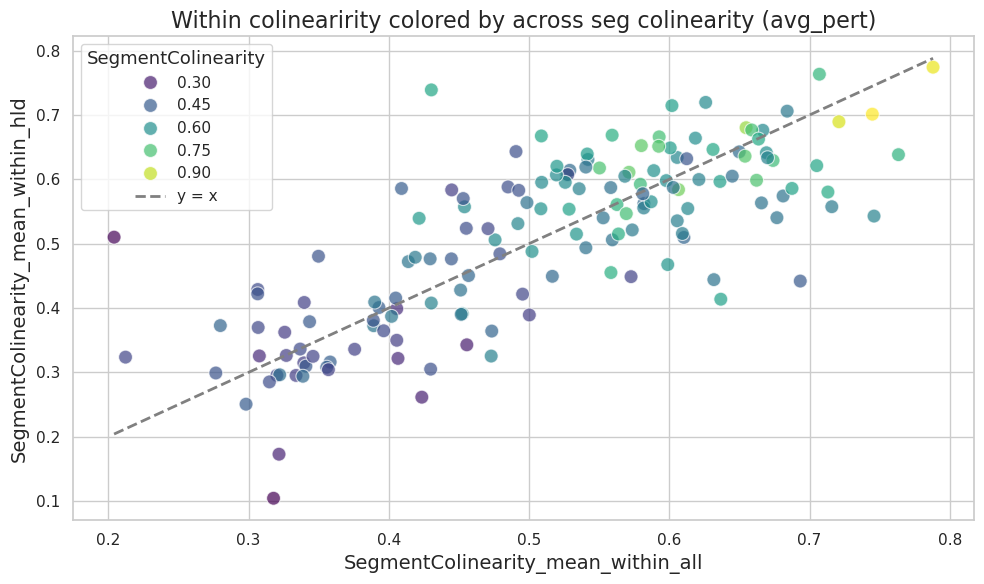

In [19]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is already defined and loaded
# Example:
# merged_df = pd.read_csv('your_data.csv')

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x='SegmentColinearity_mean_within_all',
    y='SegmentColinearity_mean_within_hld',
    hue='SegmentColinearity',
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title('Within colinearirity colored by across seg colinearity (avg_pert)', fontsize=16)
scatter_plot.set_xlabel('SegmentColinearity_mean_within_all', fontsize=14)
scatter_plot.set_ylabel('SegmentColinearity_mean_within_hld', fontsize=14)

# Add y = x line
x_min = merged_df_avg['SegmentColinearity_mean_within_all'].min()
x_max = merged_df_avg['SegmentColinearity_mean_within_all'].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')


# Improve legend
plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

/tmp/7690651.1.trapnell-login.q/ipykernel_3748861/3612110937.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_avg["beta_log10"] = np.log10(merged_df_avg["beta"])


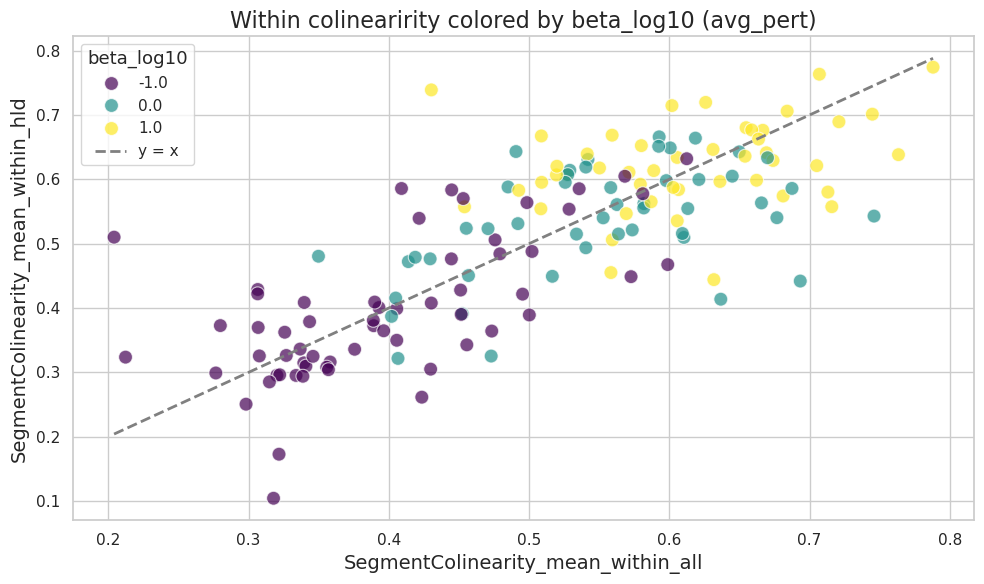

In [32]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is already defined and loaded
# Example:
# merged_df = pd.read_csv('your_data.csv')

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

merged_df_avg["beta_log10"] = np.log10(merged_df_avg["beta"])

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x='SegmentColinearity_mean_within_all',
    y='SegmentColinearity_mean_within_hld',
    hue='beta_log10',
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title('Within colinearirity colored by beta_log10 (avg_pert)', fontsize=16)
scatter_plot.set_xlabel('SegmentColinearity_mean_within_all', fontsize=14)
scatter_plot.set_ylabel('SegmentColinearity_mean_within_hld', fontsize=14)

# Add y = x line
x_min = merged_df_avg['SegmentColinearity_mean_within_all'].min()
x_max = merged_df_avg['SegmentColinearity_mean_within_all'].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')


# Improve legend
plt.legend(title='beta_log10', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

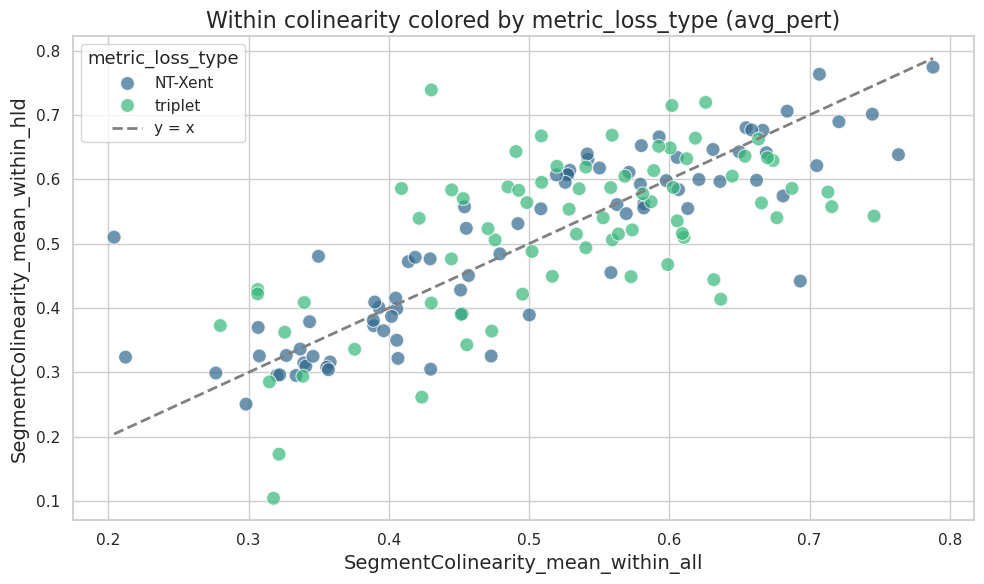

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define reusable variables
x_name = 'SegmentColinearity_mean_within_all'
y_name = 'SegmentColinearity_mean_within_hld'
col_var = 'metric_loss_type'

# Transform the variable for color mapping
# merged_df_avg[col_var] = np.log10(merged_df_avg["beta"])


# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x=x_name,
    y=y_name,
    hue=col_var,
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title(f'Within colinearity colored by {col_var} (avg_pert)', fontsize=16)
scatter_plot.set_xlabel(x_name, fontsize=14)
scatter_plot.set_ylabel(y_name, fontsize=14)

# Add y = x line
x_min = merged_df_avg[x_name].min()
x_max = merged_df_avg[x_name].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')

# Improve legend
plt.legend(title=col_var, title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

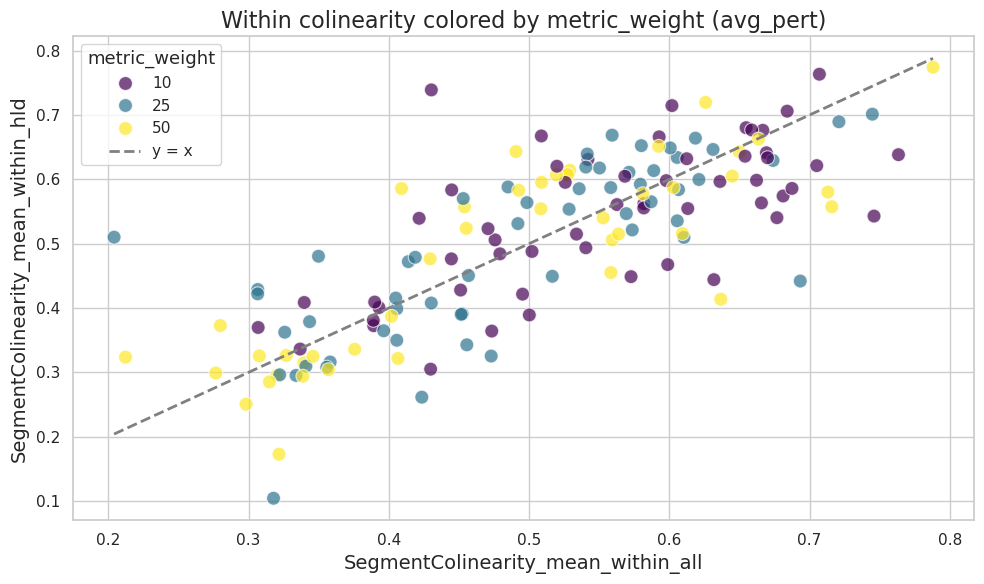

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define reusable variables
x_name = 'SegmentColinearity_mean_within_all'
y_name = 'SegmentColinearity_mean_within_hld'
col_var = 'metric_weight'

# Transform the variable for color mapping
# merged_df_avg[col_var] = np.log10(merged_df_avg["beta"])


# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x=x_name,
    y=y_name,
    hue=col_var,
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title(f'Within colinearity colored by {col_var} (avg_pert)', fontsize=16)
scatter_plot.set_xlabel(x_name, fontsize=14)
scatter_plot.set_ylabel(y_name, fontsize=14)

# Add y = x line
x_min = merged_df_avg[x_name].min()
x_max = merged_df_avg[x_name].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')

# Improve legend
plt.legend(title=col_var, title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

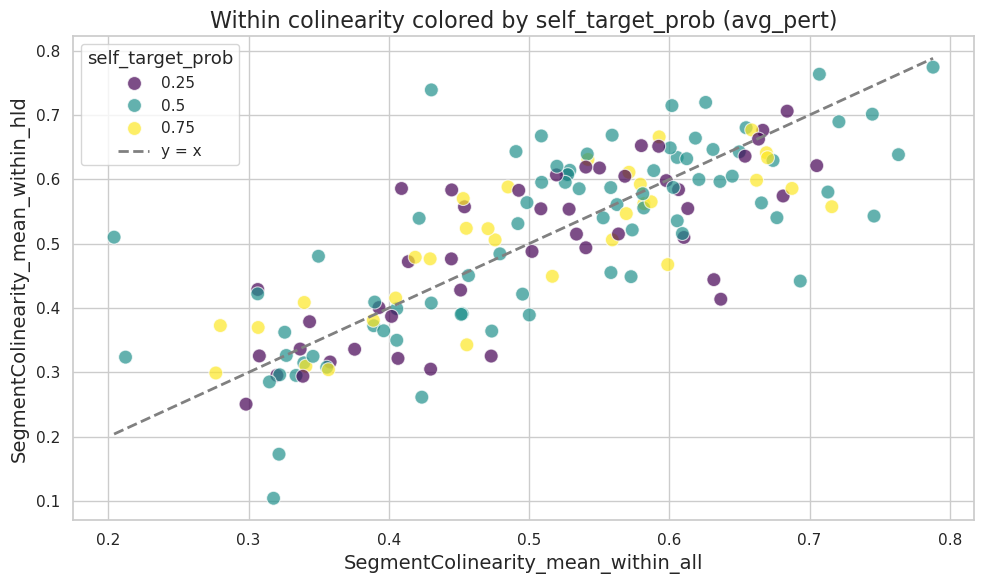

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define reusable variables
x_name = 'SegmentColinearity_mean_within_all'
y_name = 'SegmentColinearity_mean_within_hld'
col_var = 'self_target_prob'

# Transform the variable for color mapping
# merged_df_avg[col_var] = np.log10(merged_df_avg["beta"])


# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x=x_name,
    y=y_name,
    hue=col_var,
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title(f'Within colinearity colored by {col_var} (avg_pert)', fontsize=16)
scatter_plot.set_xlabel(x_name, fontsize=14)
scatter_plot.set_ylabel(y_name, fontsize=14)

# Add y = x line
x_min = merged_df_avg[x_name].min()
x_max = merged_df_avg[x_name].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')

# Improve legend
plt.legend(title=col_var, title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

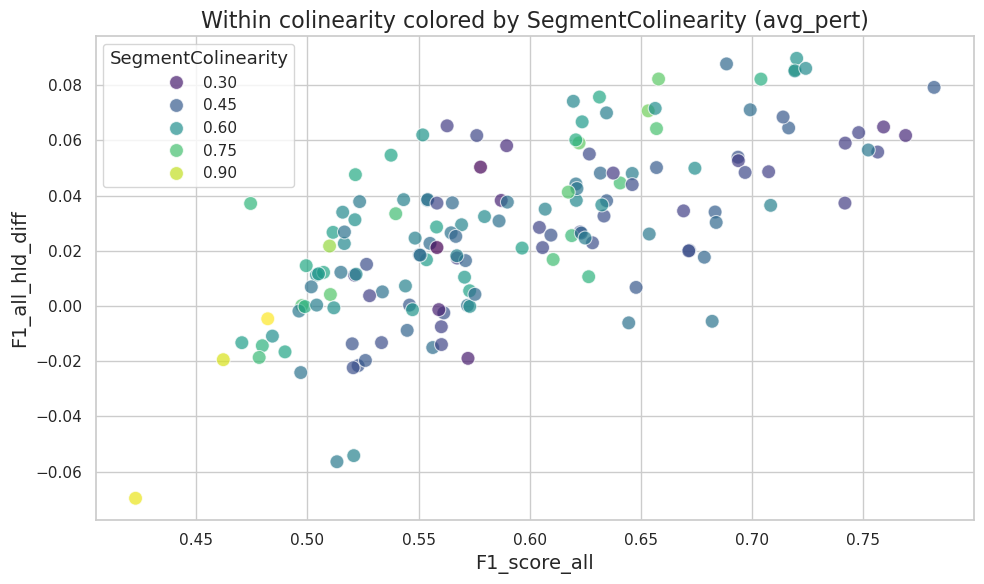

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define reusable variables
x_name = 'F1_score_all'
y_name = 'F1_all_hld_diff'
# col_var = 'F1_score_all'

# Transform the variable for color mapping
# merged_df_avg[col_var] = np.log10(merged_df_avg["beta"])

for col_var in ["SegmentColinearity"]:
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=merged_df_avg,
        x=x_name,
        y=y_name,
        hue=col_var,
        palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
        s=100,  # Size of the points
        alpha=0.7  # Transparency of the points
    )

    # Add title and labels
    scatter_plot.set_title(f'Within colinearity colored by {col_var} (avg_pert)', fontsize=16)
    scatter_plot.set_xlabel(x_name, fontsize=14)
    scatter_plot.set_ylabel(y_name, fontsize=14)

    # Add y = x line
    x_min = merged_df_avg[x_name].min()
    x_max = merged_df_avg[x_name].max()
    # plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')

    # Improve legend
    plt.legend(title=col_var, title_fontsize='13', fontsize='11')

    # Show the plot
    plt.tight_layout()
    plt.show()

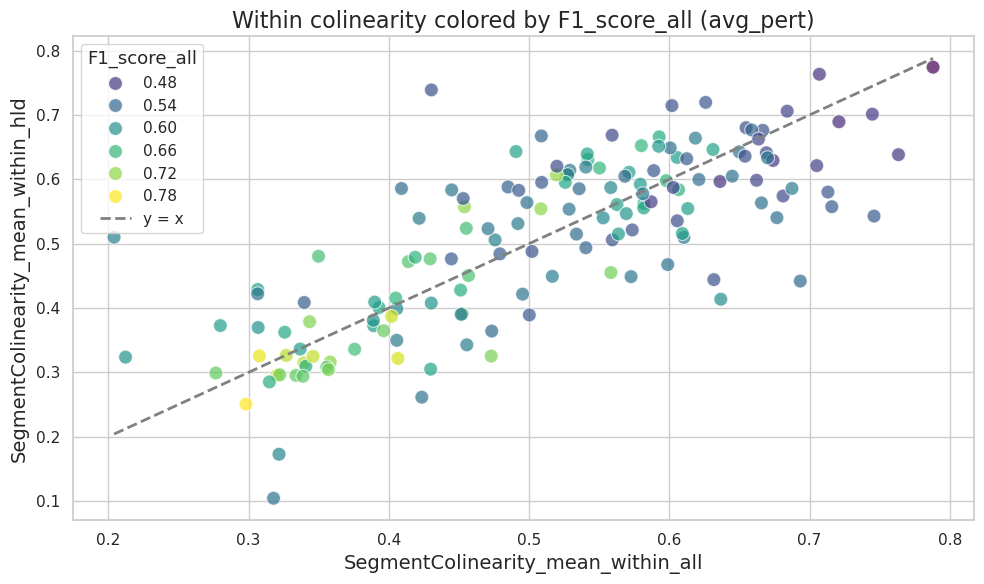

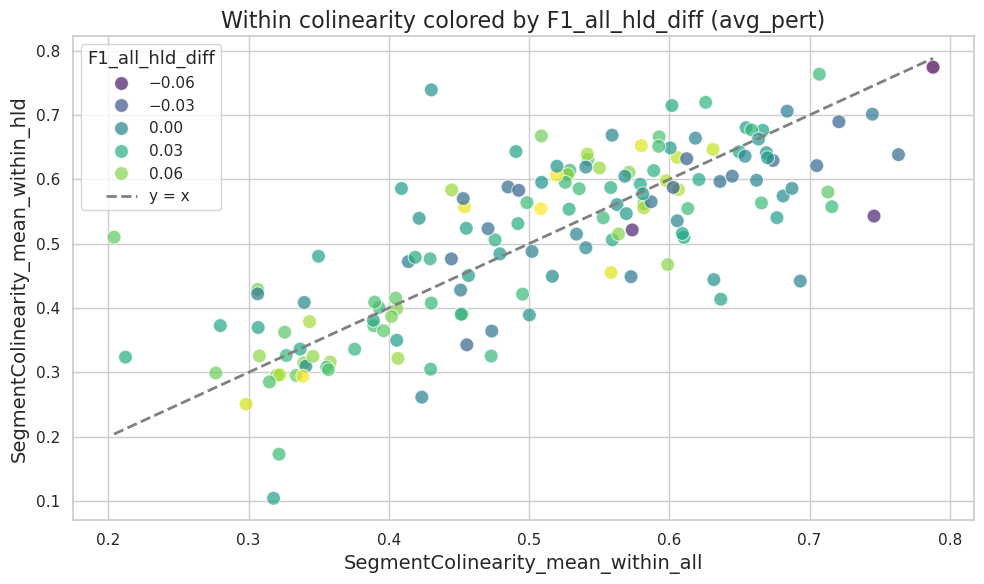

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define reusable variables
x_name = 'SegmentColinearity_mean_within_all'
y_name = 'SegmentColinearity_mean_within_hld'
# col_var = 'F1_score_all'

# Transform the variable for color mapping
# merged_df_avg[col_var] = np.log10(merged_df_avg["beta"])

for col_var in ["F1_score_all", "F1_all_hld_diff"]:
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=merged_df_avg,
        x=x_name,
        y=y_name,
        hue=col_var,
        palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
        s=100,  # Size of the points
        alpha=0.7  # Transparency of the points
    )

    # Add title and labels
    scatter_plot.set_title(f'Within colinearity colored by {col_var} (avg_pert)', fontsize=16)
    scatter_plot.set_xlabel(x_name, fontsize=14)
    scatter_plot.set_ylabel(y_name, fontsize=14)

    # Add y = x line
    x_min = merged_df_avg[x_name].min()
    x_max = merged_df_avg[x_name].max()
    plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')

    # Improve legend
    plt.legend(title=col_var, title_fontsize='13', fontsize='11')

    # Show the plot
    plt.tight_layout()
    plt.show()

# MSE Alignment

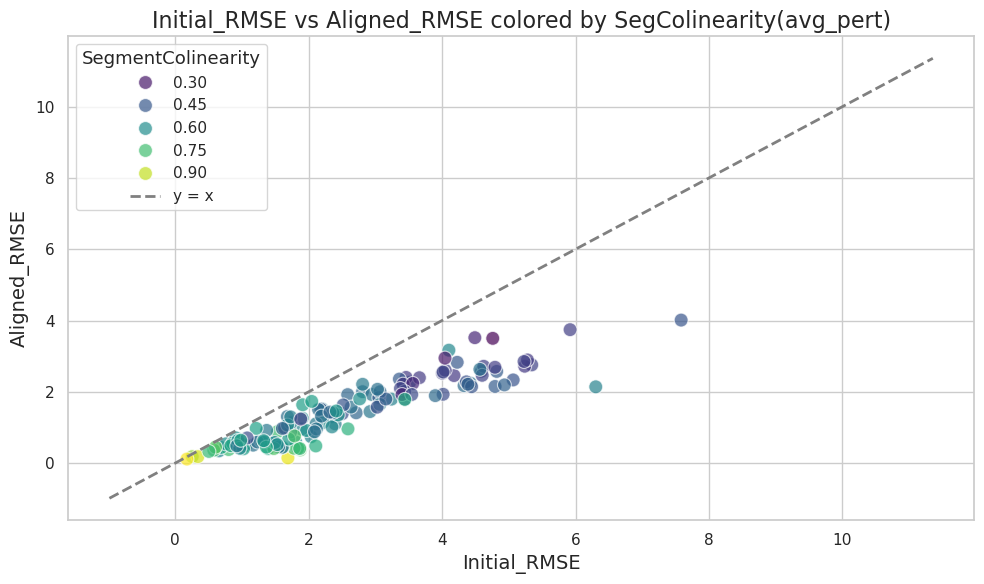

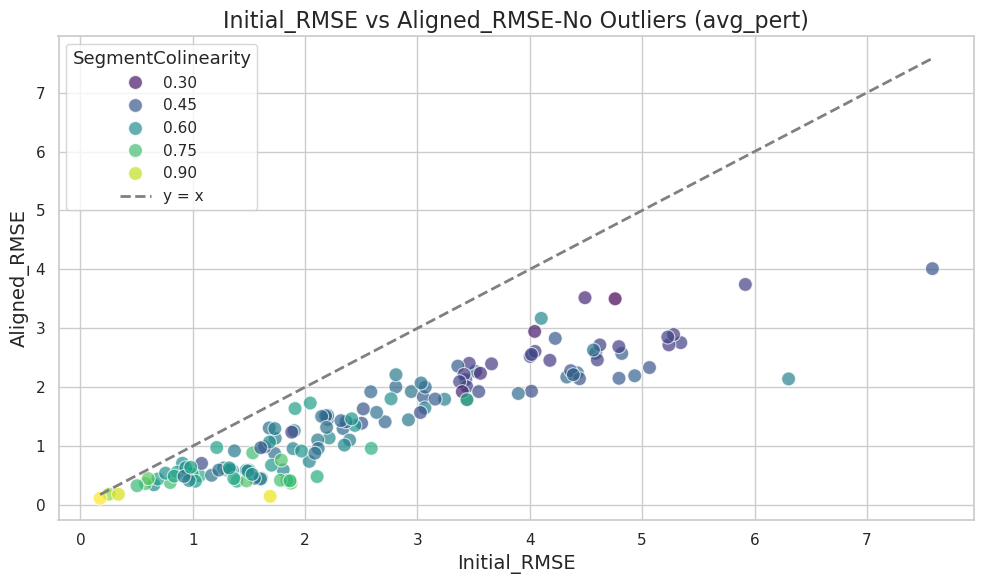

In [26]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is already defined and loaded
#  'disp_coefficient_all',
#  'disp_coefficient_hld',
#  'dispersion_first_n_all',
#  'dispersion_first_n_hld',
#  'dispersion_last_n_all',
#  'dispersion_last_n_hld',

# Set the aesthetic style of the plots
sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=filtered_df,
    x='Initial_RMSE',
    y='Aligned_RMSE',
    hue='SegmentColinearity',
    palette='viridis',
    s=100,
    alpha=0.7
)

# Add title and labels
scatter_plot.set_title('Initial_RMSE vs Aligned_RMSE colored by SegColinearity(avg_pert)', fontsize=16)
scatter_plot.set_xlabel('Initial_RMSE', fontsize=14)
scatter_plot.set_ylabel('Aligned_RMSE', fontsize=14)

# Add y = x line
x_min = merged_df_avg['disp_coefficient_all'].min()
x_max = merged_df_avg['disp_coefficient_all'].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')


# Improve legend
plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()


# Step 2: Remove Outliers using IQR
Q1 = merged_df_avg[['Initial_RMSE', 'Aligned_RMSE']].quantile(0.25)
Q3 = merged_df_avg[['Initial_RMSE', 'Aligned_RMSE']].quantile(0.75)
IQR = Q3 - Q1


# Filtering the data
filtered_df = merged_df_avg[
    ~((merged_df_avg['Initial_RMSE'] < (Q1['Initial_RMSE'] - 1.5 * IQR['Initial_RMSE'])) |
      (merged_df_avg['Initial_RMSE'] > (Q3['Initial_RMSE'] + 1.5 * IQR['Initial_RMSE'])) |
      (merged_df_avg['Aligned_RMSE'] < (Q1['Aligned_RMSE'] - 1.5 * IQR['Aligned_RMSE'])) |
      (merged_df_avg['Aligned_RMSE'] > (Q3['Aligned_RMSE'] + 1.5 * IQR['Aligned_RMSE'])))
]

# Step 3: Create Scatter Plot without Outliers
plt.figure(figsize=(10, 6))
scatter_plot_filtered = sns.scatterplot(
    data=filtered_df,
    x='Initial_RMSE',
    y='Aligned_RMSE',
    hue='SegmentColinearity',
    palette='viridis',
    s=100,
    alpha=0.7
)

# Add title, labels, and y=x line
x_min_filtered = filtered_df['Initial_RMSE'].min()
x_max_filtered = filtered_df['Initial_RMSE'].max()
plt.plot([x_min_filtered, x_max_filtered], [x_min_filtered, x_max_filtered], color='gray', linestyle='--', linewidth=2, label='y = x')

scatter_plot_filtered.set_title('Initial_RMSE vs Aligned_RMSE-No Outliers (avg_pert)', fontsize=16)
scatter_plot_filtered.set_xlabel('Initial_RMSE', fontsize=14)
scatter_plot_filtered.set_ylabel('Aligned_RMSE', fontsize=14)

# Show legend and plot
plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()

# Dispersion 

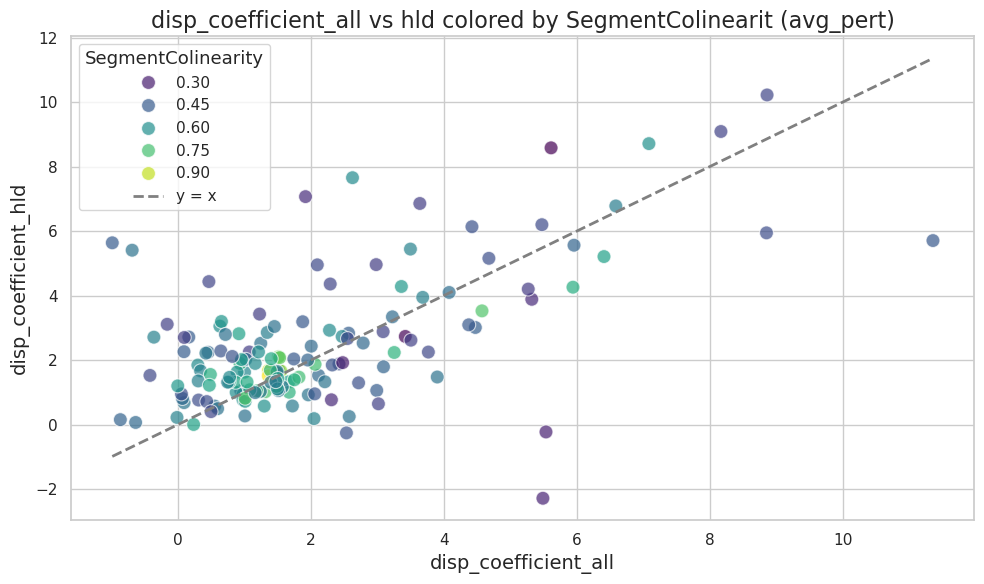

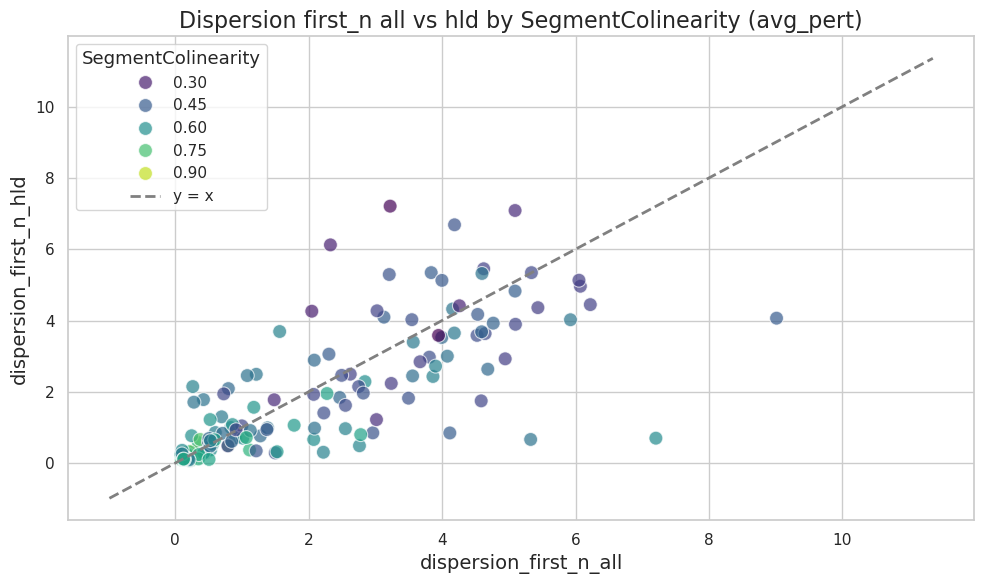

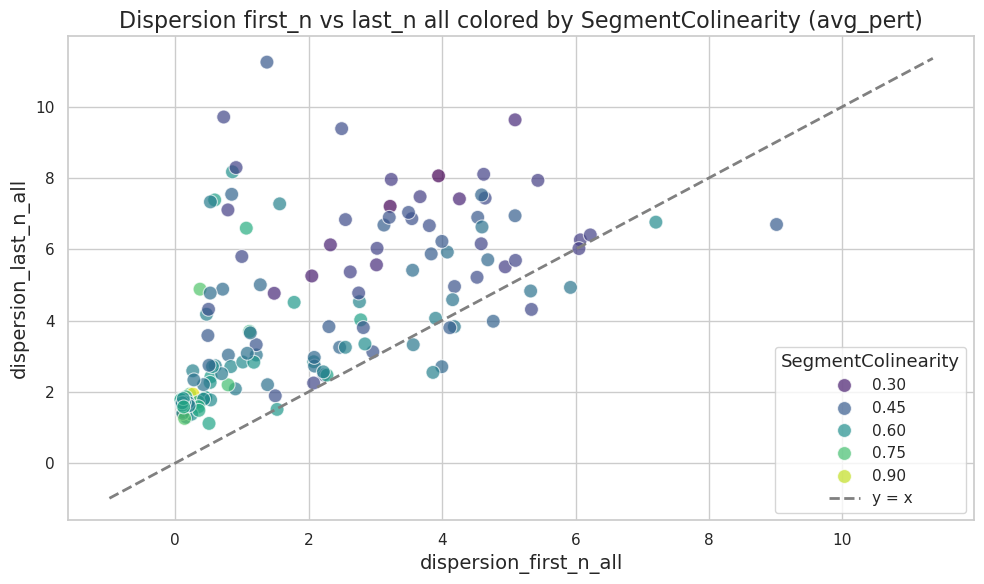

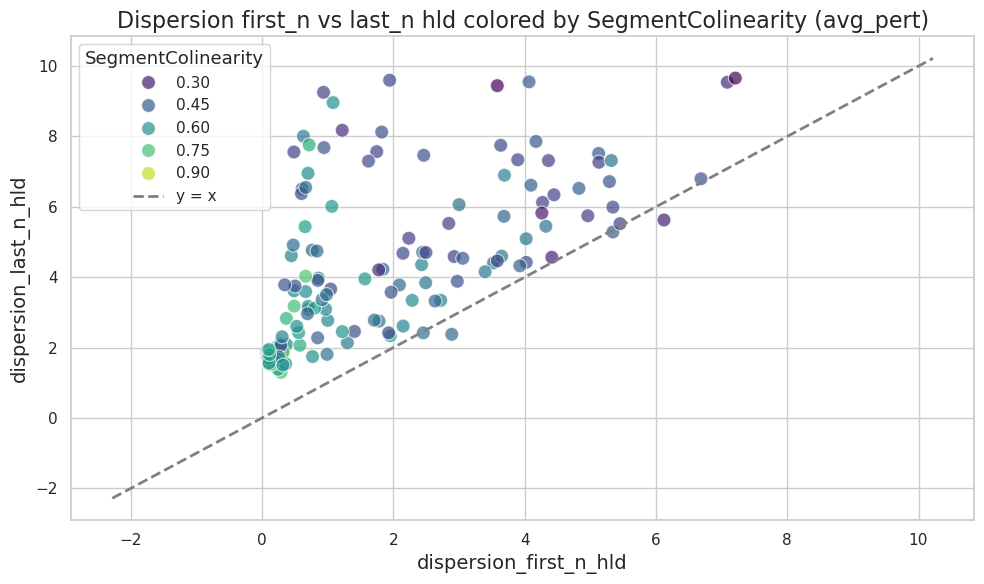

In [25]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is already defined and loaded
#  'disp_coefficient_all',
#  'disp_coefficient_hld',
#  'dispersion_first_n_all',
#  'dispersion_first_n_hld',
#  'dispersion_last_n_all',
#  'dispersion_last_n_hld',

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x='disp_coefficient_all',
    y='disp_coefficient_hld',
    hue='SegmentColinearity',
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title('disp_coefficient_all vs hld colored by SegmentColinearit (avg_pert)', fontsize=16)
scatter_plot.set_xlabel('disp_coefficient_all', fontsize=14)
scatter_plot.set_ylabel('disp_coefficient_hld', fontsize=14)

# Add y = x line
x_min = merged_df_avg['disp_coefficient_all'].min()
x_max = merged_df_avg['disp_coefficient_all'].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')


# Improve legend
plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x='dispersion_first_n_all',
    y='dispersion_first_n_hld',
    hue='SegmentColinearity',
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title('Dispersion first_n all vs hld by SegmentColinearity (avg_pert)', fontsize=16)
scatter_plot.set_xlabel('dispersion_first_n_all', fontsize=14)
scatter_plot.set_ylabel('dispersion_first_n_hld', fontsize=14)

# Add y = x line
x_min = merged_df_avg['disp_coefficient_all'].min()
x_max = merged_df_avg['disp_coefficient_all'].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')


# Improve legend
plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()


# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x='dispersion_first_n_all',
    y='dispersion_last_n_all',
    hue='SegmentColinearity',
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title('Dispersion first_n vs last_n all colored by SegmentColinearity (avg_pert)', fontsize=16)
scatter_plot.set_xlabel('dispersion_first_n_all', fontsize=14)
scatter_plot.set_ylabel('dispersion_last_n_all', fontsize=14)

# Add y = x line
x_min = merged_df_avg['disp_coefficient_all'].min()
x_max = merged_df_avg['disp_coefficient_all'].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')


# Improve legend
plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=merged_df_avg,
    x='dispersion_first_n_hld',
    y='dispersion_last_n_hld',
    hue='SegmentColinearity',
    palette='viridis',  # You can choose other palettes like 'deep', 'muted', etc.
    s=100,  # Size of the points
    alpha=0.7  # Transparency of the points
)

# Add title and labels
scatter_plot.set_title('Dispersion first_n vs last_n hld colored by SegmentColinearity (avg_pert)', fontsize=16)
scatter_plot.set_xlabel('dispersion_first_n_hld', fontsize=14)
scatter_plot.set_ylabel('dispersion_last_n_hld', fontsize=14)

# Add y = x line
x_min = merged_df_avg['disp_coefficient_hld'].min()
x_max = merged_df_avg['disp_coefficient_hld'].max()
plt.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', linewidth=2, label='y = x')


# Improve legend
plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()





# # Step 2: Remove Outliers using IQR
# Q1 = merged_df_avg[['Initial_RMSE', 'Aligned_RMSE']].quantile(0.25)
# Q3 = merged_df_avg[['Initial_RMSE', 'Aligned_RMSE']].quantile(0.75)
# IQR = Q3 - Q1


# # Filtering the data
# filtered_df = merged_df_avg[
#     ~((merged_df_avg['Initial_RMSE'] < (Q1['Initial_RMSE'] - 1.5 * IQR['Initial_RMSE'])) |
#       (merged_df_avg['Initial_RMSE'] > (Q3['Initial_RMSE'] + 1.5 * IQR['Initial_RMSE'])) |
#       (merged_df_avg['Aligned_RMSE'] < (Q1['Aligned_RMSE'] - 1.5 * IQR['Aligned_RMSE'])) |
#       (merged_df_avg['Aligned_RMSE'] > (Q3['Aligned_RMSE'] + 1.5 * IQR['Aligned_RMSE'])))
# ]

# # Step 3: Create Scatter Plot without Outliers
# plt.figure(figsize=(10, 6))
# scatter_plot_filtered = sns.scatterplot(
#     data=filtered_df,
#     x='Initial_RMSE',
#     y='Aligned_RMSE',
#     hue='SegmentColinearity',
#     palette='viridis',
#     s=100,
#     alpha=0.7
# )

# # Add title, labels, and y=x line
# x_min_filtered = filtered_df['Initial_RMSE'].min()
# x_max_filtered = filtered_df['Initial_RMSE'].max()
# plt.plot([x_min_filtered, x_max_filtered], [x_min_filtered, x_max_filtered], color='gray', linestyle='--', linewidth=2, label='y = x')

# scatter_plot_filtered.set_title('Initial_RMSE vs Aligned_RMSE-No Outliers (avg_pert)', fontsize=16)
# scatter_plot_filtered.set_xlabel('Initial_RMSE', fontsize=14)
# scatter_plot_filtered.set_ylabel('Aligned_RMSE', fontsize=14)

# # Show legend and plot
# plt.legend(title='SegmentColinearity', title_fontsize='13', fontsize='11')
# plt.tight_layout()
# plt.show()

model_index Perturbation  F1_score_all  F1_score_hld  F1_all_hld_diff  \
5              0     avg_pert      0.644516      0.650633        -0.006117   
11             1     avg_pert      0.516562      0.493950         0.022612   
17             2     avg_pert      0.626496      0.615896         0.010600   
23             3     avg_pert      0.509936      0.488213         0.021723   
29             4     avg_pert      0.526586      0.511489         0.015097   
..           ...          ...           ...           ...              ...   
905          192     avg_pert      0.504958      0.493304         0.011654   
911          194     avg_pert      0.560274      0.574247        -0.013973   
917          198     avg_pert      0.559082      0.560395        -0.001313   
923          201     avg_pert      0.558231      0.537055         0.021176   
929          206     avg_pert      0.620702      0.560519         0.060183   

     Avg_Path_Length_Diff_intra  Clustering_Coeff_Diff_intra  \
5                     -0.013545                    -0.010985   
11                     0.304737                     0.019782   
17                    -0.033027                    -0.015699   
23                     0.281098                     0.018079   
29                    -0.006095                    -0.003220   
..                          ...                          ...   
905                   -0.144373                    -0.033242   
911                    0.047969                     0.001866   
917                    0.213825                    -0.013343   
923                    0.380454                    -0.002788   
929                   -0.074716                    -0.004038   

     KL_Divergence_Diff_intra  Avg_Path_Length_Diff_inter  \
5                   -0.027873                    0.025633   
11                  -0.047723                    0.570560   
17                  -0.069806                   -0.063065   
23                  -0.061065                    0.741825   
29                  -0.020678                    0.004929   
..                        ...                         ...   
905                 -0.025737                   -0.174127   
911                 -0.049845                    0.014607   
917                 -0.611206                    0.553507   
923                 -0.064871                    0.159131   
929                 -0.018036                   -0.101310   

     Clustering_Coeff_Diff_inter  ...  latent_dim  beta  batch_size  zn_frac  \
5                       0.005243  ...         100   0.1        2048      0.2   
11                      0.038490  ...         100  10.0        2048      0.2   
17                     -0.007161  ...         100   1.0        2048      0.2   
23                      0.026475  ...         100  10.0        2048      0.2   
29                      0.003490  ...         100   0.1        2048      0.2   
..                           ...  ...         ...   ...         ...      ...   
905                    -0.026798  ...         100  10.0        2048      0.2   
911                    -0.001166  ...         100   1.0        2048      0.2   
917                    -0.007271  ...         100   0.1        2048      0.2   
923                    -0.006899  ...         100   0.1        2048      0.2   
929                    -0.005291  ...         100   1.0        2048      0.2   

     process_id_hld  process_id_nohld  \
5               417               136   
11              231               403   
17               20               311   
23              283               241   
29               12               378   
..              ...               ...   
905             166               143   
911             268               336   
917             275               226   
923             230                21   
929             206                 8   

                                        model_path_hld  \
5    /net/trapnell/vol1/home/nlammers/projects/data...

# Selecting model 

In [6]:
imp_cols = ["model_index","Perturbation"] + \
     ['metric_loss_type','beta', 'time_only_flag', 'self_target_prob','margin', 'metric_weight'] +\
        ["F1_score_all", "F1_score_hld", "Aligned_RMSE","SegmentColinearity","SegmentColinearity_mean_within_all","dispersion_first_n_all","disp_coefficient_all"]
imp_cols

['model_index',
 'Perturbation',
 'metric_loss_type',
 'beta',
 'time_only_flag',
 'self_target_prob',
 'margin',
 'metric_weight',
 'F1_score_all',
 'F1_score_hld',
 'Aligned_RMSE',
 'SegmentColinearity',
 'SegmentColinearity_mean_within_all',
 'dispersion_first_n_all',
 'disp_coefficient_all']

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/8358430.1.trapnell-login.q/ipykernel_839571/3315263016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_avg["beta_log10"] = np.log10(merged_df_avg["beta"])
/tmp/8358430.1.trapnell-login.q/ipykernel_839571/3315263016.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

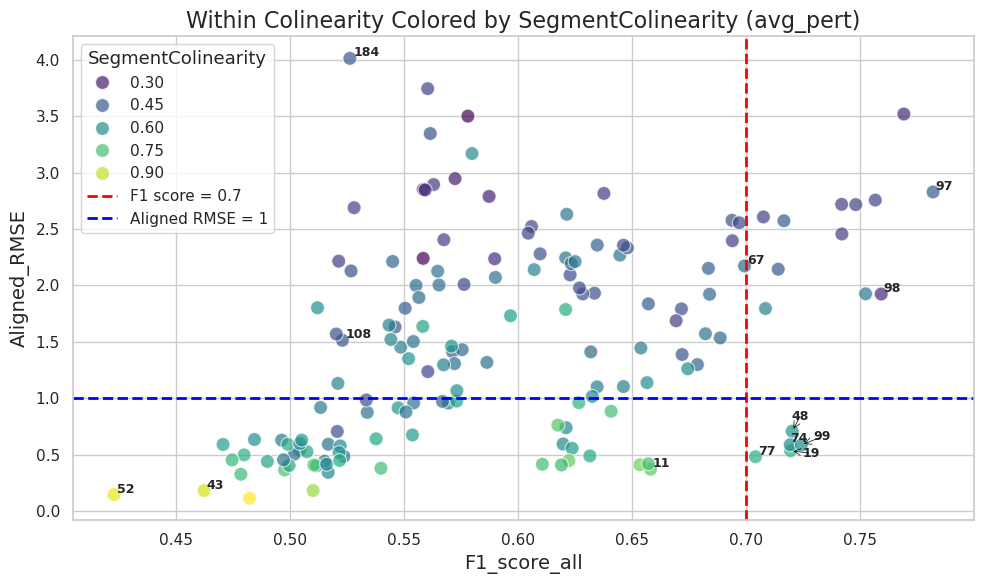

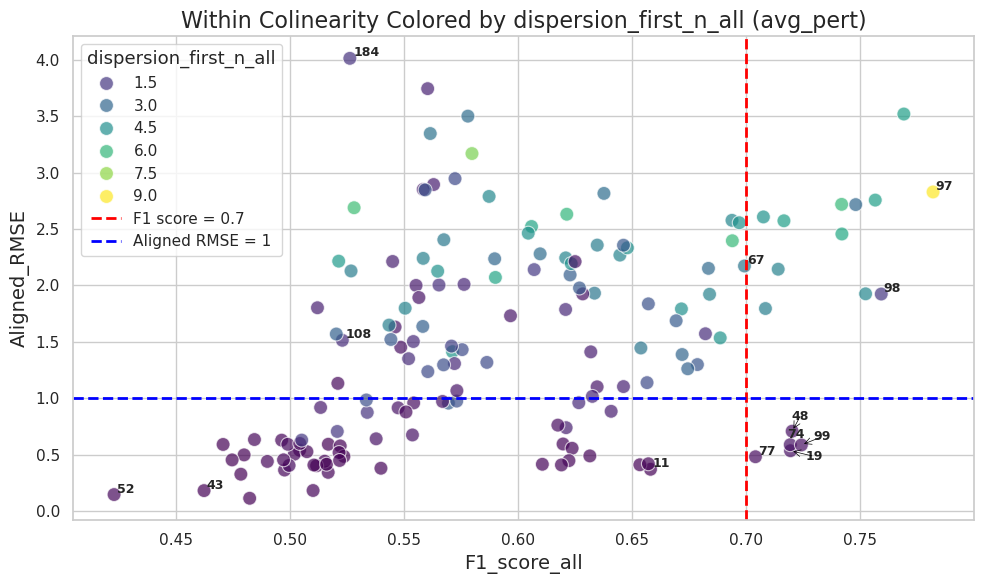

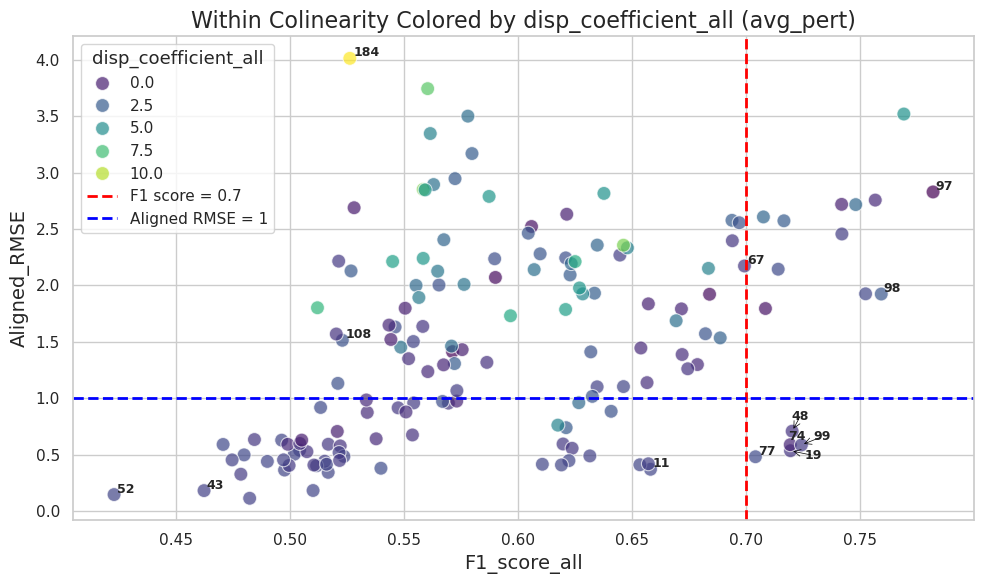

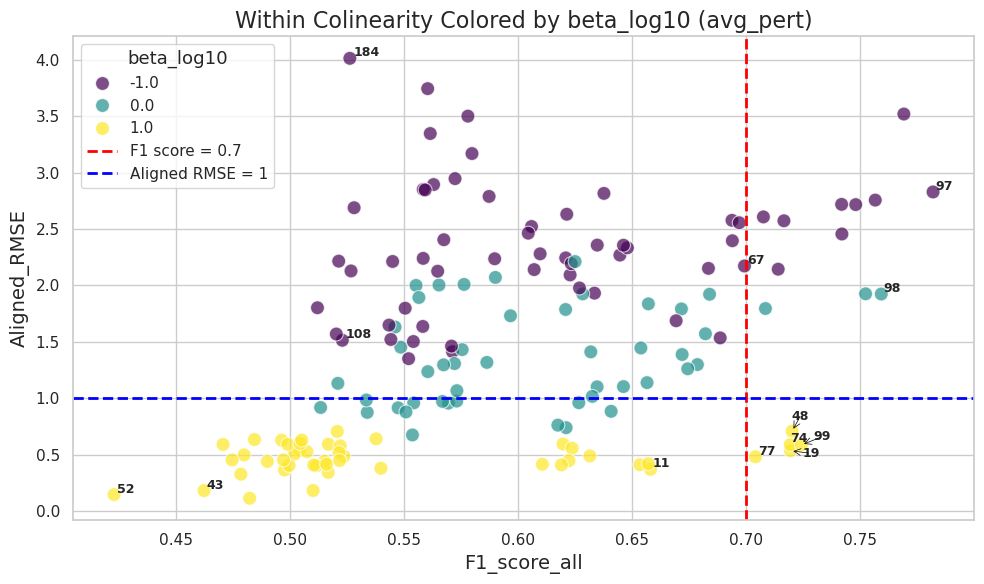

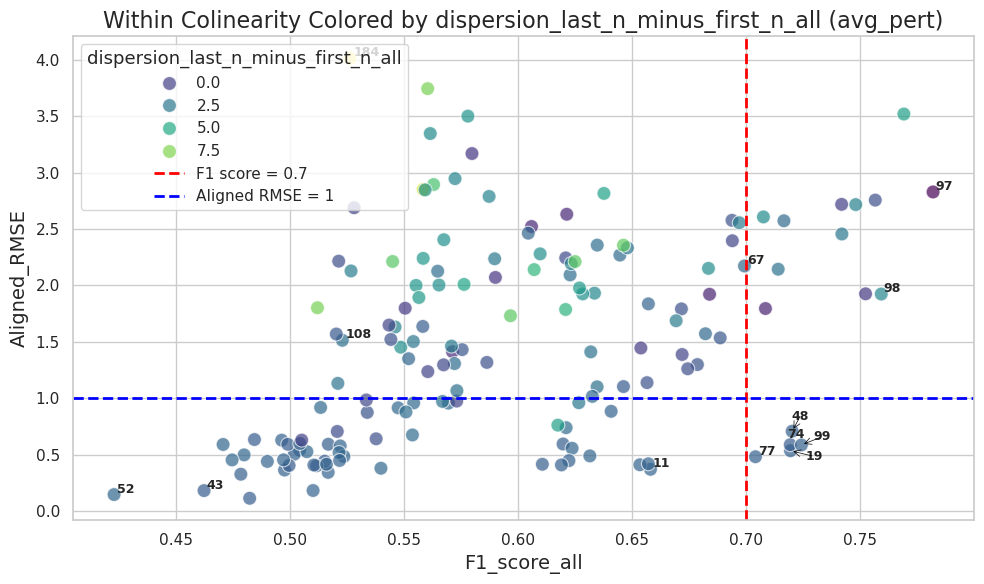

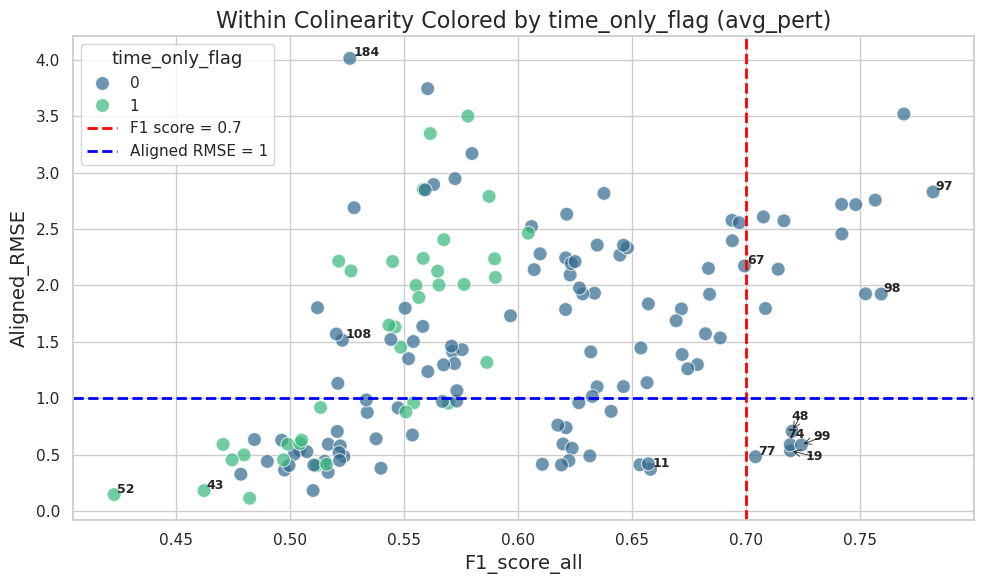

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define reusable variables
x_name = 'F1_score_all'
y_name = 'Aligned_RMSE'

merged_df_avg["beta_log10"] = np.log10(merged_df_avg["beta"])

merged_df_avg["dispersion_last_n_minus_first_n_all"] = merged_df_avg["dispersion_last_n_all"] - merged_df_avg["dispersion_first_n_all"]

# List of model indices to label
label_model_indices = [11,98, 97, 52, 43, 99, 48, 19, 74, 77,108,67,184]

for col_var in ["SegmentColinearity", "dispersion_first_n_all", "disp_coefficient_all", "beta_log10","dispersion_last_n_minus_first_n_all","time_only_flag"]:
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=merged_df_avg,
        x=x_name,
        y=y_name,
        hue=col_var,
        palette='viridis',  # Palette for coloring
        s=100,              # Size of points
        alpha=0.7           # Transparency
    )

    # Add title and labels
    scatter_plot.set_title(f'Within Colinearity Colored by {col_var} (avg_pert)', fontsize=16)
    scatter_plot.set_xlabel(x_name, fontsize=14)
    scatter_plot.set_ylabel(y_name, fontsize=14)

    # Add vertical and horizontal reference lines
    plt.axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='F1 score = 0.7')
    plt.axhline(y=1, color='blue', linestyle='--', linewidth=2, label='Aligned RMSE = 1')

    # Improve legend
    plt.legend(title=col_var, title_fontsize='13', fontsize='11')

    # Filter the DataFrame for the specified model indices
    labeled_points = merged_df_avg[merged_df_avg["model_index"].isin(label_model_indices)]

    # Initialize a list to hold text annotations
    texts = []

    # Iterate over the filtered points and create annotations
    for _, row in labeled_points.iterrows():
        texts.append(
            plt.text(
                row[x_name],
                row[y_name],
                str(row["model_index"]),
                fontsize=9,
                weight='bold'
            )
        )

    # Adjust text to minimize overlaps and add arrows pointing to the points
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='->', color='black', lw=0.5),
        expand_points=(1.2, 1.4),
        expand_text=(1.2, 1.4),
        force_points=0.2,
        force_text=0.2,
        lim=1000
    )

    # Show the plot
    plt.tight_layout()
    plt.show()

# Aligned MSE >1 F1 score <.7 (Subset)

In [35]:
merged_df_avg[(merged_df_avg["Aligned_RMSE"] > 1) & (merged_df_avg["F1_score_all"] < 0.7) & (merged_df_avg["model_index"].isin([108,67,184]))][imp_cols].sort_values(by="F1_score_all", ascending=False)

model_index Perturbation metric_loss_type  beta  time_only_flag  \
323           67     avg_pert          NT-Xent   0.1               0   
881          184     avg_pert          triplet   0.1               0   
515          108     avg_pert          triplet   0.1               0   

     self_target_prob  margin  metric_weight  F1_score_all  F1_score_hld  \
323              0.50     2.0             25      0.699149      0.628076   
881              0.25     5.0             10      0.526068      0.545798   
515              0.50     0.1             10      0.522775      0.544393   

     Aligned_RMSE  SegmentColinearity  SegmentColinearity_mean_within_all  \
323      2.171811            0.499992                            0.322169   
881      4.012054            0.443271                            0.444577   
515      1.513283            0.435893                            0.612368   

     dispersion_first_n_all  disp_coefficient_all  
323                3.557945              1.022507  
881                1.374297             11.356005  
515                1.213509              2.058222

# Aligned MSE <=1 F1 score <.7 (Subset)

In [37]:
merged_df_avg[(merged_df_avg["Aligned_RMSE"] <= 1) & (merged_df_avg["F1_score_all"] < 0.7) & (merged_df_avg["model_index"].isin([52,43,11]))][imp_cols].sort_values(by="F1_score_all", ascending=False)

model_index Perturbation metric_loss_type  beta  time_only_flag  \
59            11     avg_pert          NT-Xent  10.0               0   
215           43     avg_pert          NT-Xent  10.0               1   
257           52     avg_pert          NT-Xent  10.0               1   

     self_target_prob  margin  metric_weight  F1_score_all  F1_score_hld  \
59               0.25     0.1             25      0.657936      0.575697   
215              0.50     1.0             25      0.462121      0.481579   
257              0.50     1.0             50      0.422659      0.492315   

     Aligned_RMSE  SegmentColinearity  SegmentColinearity_mean_within_all  \
59       0.369914            0.779365                            0.580015   
215      0.180996            0.920061                            0.720897   
257      0.146000            0.940644                            0.788008   

     dispersion_first_n_all  disp_coefficient_all  
59                 0.146752              1.528816  
215                0.128076              1.363076  
257                0.266395              1.485208

# Aligned MSE >1 F1 score >.7 (Subset)

In [7]:
merged_df_avg[(merged_df_avg["Aligned_RMSE"] > 1) & (merged_df_avg["F1_score_all"] > 0.7)& (merged_df_avg["model_index"].isin([97,98]))][imp_cols].sort_values(by="F1_score_all", ascending=False)

model_index Perturbation metric_loss_type  beta  time_only_flag  \
467           97     avg_pert          NT-Xent   0.1               0   
473           98     avg_pert          NT-Xent   1.0               0   

     self_target_prob  margin  metric_weight  F1_score_all  F1_score_hld  \
467              0.25     5.0             50      0.781858      0.702657   
473              0.25     5.0             50      0.759139      0.694277   

     Aligned_RMSE  SegmentColinearity  SegmentColinearity_mean_within_all  \
467      2.827774            0.447553                            0.298167   
473      1.923200            0.325243                            0.406500   

     dispersion_first_n_all  disp_coefficient_all  
467                9.013367             -0.986660  
473                1.483292              2.308945

# Aligned MSE < 1 F1 score >.7 (BEST MODELS)

In [27]:
# self_df = merged_df_avg[(merged_df_avg["Aligned_RMSE"] <= 1) & (merged_df_avg["F1_score_all"] > 0.7)]
# # self_df[imp_cols]
merged_df_avg[(merged_df_avg["Aligned_RMSE"] <= 1) & (merged_df_avg["F1_score_all"] > 0.7)][imp_cols].sort_values(by="F1_score_all", ascending=False)

model_index Perturbation metric_loss_type  beta  time_only_flag  \
479           99     avg_pert          NT-Xent  10.0               0   
245           48     avg_pert          NT-Xent  10.0               0   
101           19     avg_pert          NT-Xent  10.0               0   
365           74     avg_pert          NT-Xent  10.0               0   
377           77     avg_pert          NT-Xent  10.0               0   

     self_target_prob  margin  metric_weight  F1_score_all  F1_score_hld  \
479              0.25     5.0             50      0.724121      0.638041   
245              0.25     1.0             50      0.720055      0.630332   
101              0.25     0.1             50      0.719329      0.633751   
365              0.25     2.0             50      0.719221      0.634051   
377              0.50     2.0             50      0.703967      0.621768   

     Aligned_RMSE  SegmentColinearity  SegmentColinearity_mean_within_all  \
479      0.585608            0.587616                            0.519465   
245      0.707545            0.610988                            0.508386   
101      0.534260            0.710807                            0.526650   
365      0.587776            0.587008                            0.453926   
377      0.481153            0.697584                            0.558336   

     dispersion_first_n_all  disp_coefficient_all  
479                0.425045              1.162380  
245                0.456199              0.890601  
101                0.451727              0.934226  
365                0.530416              0.300422  
377                0.347210              1.751113

In [101]:

def plot_trajectories_3d(splines_final,save_dir=None):
    """
    Plots PCA trajectories for different perturbations and datasets in a 3D Plotly plot.

    Parameters:
    splines_final (pd.DataFrame): DataFrame containing the trajectory data with columns
                                  ['dataset', 'Perturbation', 'point_index', 'PCA_1', 'PCA_2', 'PCA_3']

    Returns:
    None
    """
    # Define perturbations and their corresponding colors
    pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
    
    color_map = {
        "wnt-i": "red",
        "tgfb-i": "green",
        "wt": "blue",
        "lmx1b": "orange",
        "gdf3": "purple"
    }
    
    # Define dataset styles with dash styles
    dataset_styles = {
        "all": {"dash": "solid", "name": "all"},
        "hld": {"dash": "dash", "name": "hld"},
        "hld_aligned": {"dash": "dot", "name": "hld aligned"}
    }
    
    # Initialize the figure
    fig = go.Figure()

    # Iterate over each perturbation
    for pert in pert_comparisons:
        pert_data = splines_final[splines_final['Perturbation'] == pert]
        color = color_map.get(pert, "black")  # Default to black if perturbation not found
        
        # Iterate over each dataset
        for dataset, style in dataset_styles.items():
            dataset_data = pert_data[pert_data['dataset'] == dataset]
            
            if dataset_data.empty:
                continue  # Skip if there's no data for this dataset
            
            # Sort by point_index to ensure proper trajectory
            dataset_data = dataset_data.sort_values(by='point_index')
            
            # Add trace
            fig.add_trace(
                go.Scatter3d(
                    x=dataset_data['PCA_1'],
                    y=dataset_data['PCA_2'],
                    z=dataset_data['PCA_3'],
                    mode='lines',
                    name=f"{pert} - {style['name']}",
                    line=dict(color=color, dash=style['dash'], width=4),
                    )
                )
    if save_dir:
        fig.write_htlm(os.path.join(save_dir,"model_splines.html"))    
 
    # Show the plot
    return fig

In [70]:
splines_final_df

model_index      dataset Perturbation  point_index     PCA_1  \
0                  0          all        wnt-i          499  1.171707   
1                  0          all        wnt-i          498  1.174855   
2                  0          all        wnt-i          497  1.171396   
3                  0          all        wnt-i          496  1.160293   
4                  0          all        wnt-i          495  1.147365   
...              ...          ...          ...          ...       ...   
1162495          206  hld_aligned         gdf3          495  0.464563   
1162496          206  hld_aligned         gdf3          496  0.407652   
1162497          206  hld_aligned         gdf3          497  0.375973   
1162498          206  hld_aligned         gdf3          498  0.358081   
1162499          206  hld_aligned         gdf3          499  0.317935   

            PCA_2     PCA_3  
0        2.136021  5.710317  
1        2.127951  5.719100  
2        2.094452  5.733364  
3        2.058272  5.733019  
4        2.022980  5.728151  
...           ...       ...  
1162495 -0.205353  3.202789  
1162496 -0.263702  3.126092  
1162497 -0.316833  3.032464  
1162498 -0.364730  2.932380  
1162499 -0.413042  2.840430  

[1162500 rows x 7 columns]

# Storing data from selected models!

In [8]:
import os
import pandas as pd
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px

# Make sure all required functions and classes are imported
# from your local modules, for example:
# from your_module import LocalPrincipalCurve, logistic_regression_multiclass, split_train_test, f1_score_over_time_multiclass, plot_f1_score_over_time, plot_trajectories_3d

# Define perturbations before the loop
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
# Define perturbations before the loop
# pert_comparisons = ["lmx1b"]

# Initialize spline dictionary
splines_dict = {}

# for model_index in [11,98, 97, 52, 43, 99, 48, 19, 74, 77,108,67,184]:
# for model_index in [48,100,19,0]:
# for model_index in [11, 97, 52, 43, 99, 48, 19, 74, 77,108,67,184,98]:
for model_index in [19]:
    print(model_index)

    model_results_path = os.path.join('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/202412118/',
                                      f"model_results_sel/model_index_{model_index}")
    # Ensure directory exists
    os.makedirs(model_results_path, exist_ok=True)

    # Use model_results_path as save_dir
    save_dir = model_results_path

    # Assuming merged_df_avg is defined somewhere above this code:
    path_all = merged_df_avg[merged_df_avg["model_index"] == model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"] == model_index]["embryo_df_path_hld"].iloc[0]

    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    # Define z_mu columns after loading the data
    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

    # We'll use the same color mapping logic across datasets
    # We'll define the color map once outside the inner loop
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(pert_comparisons)}

    # for df_label, df in [("all", df_all), ("hld", df_hld)]:
    #     fig = go.Figure()

    #     X = df[z_mu_biological_columns].values
    #     pca = PCA(n_components=3)
    #     pcs = pca.fit_transform(X)

    #     df['color'] = df['phenotype'].map(color_discrete_map)

    #     df["PCA_1"] = pcs[:, 0]
    #     df["PCA_2"] = pcs[:, 1]
    #     df["PCA_3"] = pcs[:, 2]
        
    #     # PCA results  are pretty big things to save so not saving them here
    #     # pca_save_path = os.path.join(save_dir, f"{df_label}_pca_model_{model_index}.csv")
    #     # df.to_csv(pca_save_path, index=False)
    #     # print(f"Saved PCA DataFrame to {pca_save_path}")

    #     # Process each perturbation
    #     for pert in pert_comparisons:
    #         print(f"Processing {pert} in {df_label} dataset...")

    #         # Filter the DataFrame for the given perturbation
    #         pert_df = df[df["phenotype"] == pert]
    #         pert_3d = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values

    #         avg_early_timepoint = pert_df[
    #             (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
    #             (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
    #         ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

    #         avg_late_timepoint = pert_df[(pert_df["predicted_stage_hpf"] >= (pert_df["predicted_stage_hpf"].max() -3))][["PCA_1", "PCA_2", "PCA_3"]].mean().values


    #         # Downsampling logic
    #         if len(pert_3d) > 0:  # Ensure we have data points
    #             if pert == "wt":
    #                 subset_size = int(0.05 * len(pert_3d))
    #             else:
    #                 subset_size = int(0.1 * len(pert_3d))

    #             # Ensure subset_size is at least 1
    #             subset_size = max(1, subset_size)

    #             pert_3d_subset = pert_3d[np.random.RandomState(42).choice(len(pert_3d), 
    #                                                                       size=subset_size, 
    #                                                                       replace=False)]
    #             print(f"Subset size: {len(pert_3d_subset)}")

    #             # Fit the Local Principal Curve on the subset
    #             lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=250, tol=1e-3, angle_penalty_exp=2)
    #             paths = lpc.fit(pert_3d_subset, start_points=avg_early_timepoint,end_point=avg_late_timepoint, remove_similar_end_start_points=True)

    #             # Extract the first path (assuming one main path)
    #             spline_points = lpc.cubic_splines[0] if len(lpc.cubic_splines) > 0 else None

                

    #             # Store the spline points in the dictionary
    #             splines_dict[(df_label, pert)] = spline_points

    #             # Add the original points of this perturbation to the figure
    #             fig.add_trace(
    #                 go.Scatter3d(
    #                     x=pert_3d_subset[:, 0],
    #                     y=pert_3d_subset[:, 1],
    #                     z=pert_3d_subset[:, 2],
    #                     mode='markers',
    #                     marker=dict(
    #                         size=3,
    #                         opacity=0.1
    #                     ),
    #                     name=f"{pert} Data ({df_label})",
    #                     showlegend=True,
    #                     marker_color=color_discrete_map[pert]
    #                 )
    #             )

    #             # Add the cubic spline curve for this perturbation
    #             if spline_points is not None:
    #                 fig.add_trace(
    #                     go.Scatter3d(
    #                         x=spline_points[:, 0],
    #                         y=spline_points[:, 1],
    #                         z=spline_points[:, 2],
    #                         mode='lines',
    #                         line=dict(width=8),
    #                         name=f"{pert} Cubic Spline ({df_label})",
    #                         showlegend=True,
    #                         line_color=color_discrete_map[pert]
    #                     )
    #                 )

    #     # Update layout for a clean look
    #     fig.update_layout(
    #         scene=dict(
    #             xaxis_title='PCA_1',
    #             yaxis_title='PCA_2',
    #             zaxis_title='PCA_3'
    #         ),
    #         title=f"Local Principal Curves for Multiple Perturbations ({df_label})"
    #     )

    #     # Save the figure for this dataset
    #     fig.write_html(os.path.join(save_dir, f"{df_label}_splines_n_points_{model_index}.html"))

    # If you have a spline_df or want to create one from splines_dict, do so here.
    # For now, either remove or comment out the following line if spline_df is not defined:
    # plot_trajectories_3d(spline_df, save_dir=model_results_path)

    # Split the data
    df_all_train, df_all_test, df_all = split_train_test(df_all)
    df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)

    # Logistic Regression for 'all' data
    y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
        df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons, tol=0.0001
    )

    # Logistic Regression for 'hld' data
    y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
        df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons, tol=0.0001
    )

    results_dict_all = f1_score_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=20, max_hpf=40)
    dataset_label_all = f'model__{model_index}_all_perts_F1_tol_10e-4'
    plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label_all,
                            title="F1 Score Over Time for Perturbations", save_dir=model_results_path,plot=False)

    results_dict_hld = f1_score_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=20, max_hpf=40)
    dataset_label_hld = f'model__{model_index}_hld_gdf3_lmx1b_perts_F1_10e-4'
    plot_f1_score_over_time(results_dict_hld, pert_comparisons, dataset_label=dataset_label_hld,
                            title="F1 Score Over Time for Perturbations", save_dir=model_results_path, plot=False)



19


/tmp/7846676.1.trapnell-login.q/ipykernel_2210548/3294807973.py:38: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7846676.1.trapnell-login.q/ipykernel_2210548/3294807973.py:39: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:136: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

F1 score plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/202412118/model_results_sel/model_index_19/f1_score_over_time_multiclass_model__19_all_perts_F1_tol_10e-4.png
F1 score plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/202412118/model_results_sel/model_index_19/f1_score_over_time_multiclass_model__19_hld_gdf3_lmx1b_perts_F1_10e-4.png


In [80]:
self_df = merged_df_avg[(merged_df_avg["Aligned_RMSE"] > 1) & (merged_df_avg["F1_score_all"] > 0.7)]
self_df[imp_cols]

model_index Perturbation metric_loss_type  beta  time_only_flag  \
53             9     avg_pert          NT-Xent   0.1               0   
95            18     avg_pert          NT-Xent   0.1               0   
107           20     avg_pert          NT-Xent   0.1               0   
179           37     avg_pert          NT-Xent   1.0               0   
233           46     avg_pert          NT-Xent   0.1               0   
239           47     avg_pert          NT-Xent   1.0               0   
263           53     avg_pert          NT-Xent   0.1               0   
371           75     avg_pert          NT-Xent   0.1               0   
431           88     avg_pert          NT-Xent   0.1               0   
467           97     avg_pert          NT-Xent   0.1               0   
473           98     avg_pert          NT-Xent   1.0               0   
485          100     avg_pert          NT-Xent   0.1               0   

     self_target_prob  margin  metric_weight  F1_score_all  F1_score_hld  \
53               0.25     0.1             25      0.716457      0.651946   
95               0.25     0.1             50      0.769058      0.707290   
107              0.50     0.1             50      0.741882      0.682876   
179              0.25     1.0             25      0.708352      0.671893   
233              0.25     1.0             50      0.756505      0.700733   
239              0.25     1.0             50      0.752269      0.695757   
263              0.75     1.0             50      0.707447      0.658815   
371              0.50     2.0             50      0.747942      0.685123   
431              0.25     5.0             25      0.713932      0.645467   
467              0.25     5.0             50      0.781858      0.702657   
473              0.25     5.0             50      0.759139      0.694277   
485              0.50     5.0             50      0.741761      0.704480   

     Aligned_RMSE  SegmentColinearity  SegmentColinearity_mean_within_all  \
53       2.572208            0.459494                            0.358125   
95       3.518458            0.326463                            0.307638   
107      2.455242            0.371765                            0.339380   
179      1.794768            0.558907                            0.472949   
233      2.755715            0.393297                            0.320177   
239      1.925031            0.530933                            0.401906   
263      2.606461            0.383928                            0.356911   
371      2.715806            0.385766                            0.345928   
431      2.143305            0.443829                            0.343479   
467      2.827774            0.447553                            0.298167   
473      1.923200            0.325243                            0.406500   
485      2.717930            0.371961                            0.326876   

     dispersion_first_n_all  
53                 5.093684  
95                 5.093914  
107                5.436040  
179                3.863107  
233                5.099957  
239                4.183254  
263                4.623699  
371                3.025175  
431                3.997312  
467                9.013367  
473                1.483292  
485                6.051698

In [5]:
# for model_index in self_df["model_index"].unique():
# for model_index in [19,48,74,99,98,100]:
for model_index in [48,100,19,0]:

    print(model_index)

    model_results_path = os.path.join('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241216/',f"model_results_test4/model_index_{model_index}")


    spline_df = splines_final_df[splines_final_df["model_index"]==model_index]


    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]


    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)
    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

    # df = df_all.copy()
    df = df_hld.copy()
    X = df[z_mu_biological_columns].values
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    perturbations = pert_comparisons

    # Map perturbations to colors
    if perturbations is None:
        perturbations = df['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


    # Prepare the color array
    df['color'] = df['phenotype'].map(color_discrete_map)


    df["PCA_1"] = pcs[:,0]
    df["PCA_2"] = pcs[:,1]
    df["PCA_3"] = pcs[:,2]

    pert = "lmx1b"


    pert_df = df[df["phenotype"] == pert].reset_index(drop=True)

    # Calculate early time point
    avg_early_timepoint = pert_df[
        (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
        (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
    ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

    avg_late_timepoint = pert_df[(pert_df["predicted_stage_hpf"] >= (pert_df["predicted_stage_hpf"].max() -3))][["PCA_1", "PCA_2", "PCA_3"]].mean().values


        # Downsampling logic
    if pert == "wt":
        pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
    else:
        pert_df_subset = pert_df.sample(frac=.1, random_state=42)

    print(f"Subset size: {len(pert_df_subset)}")


    pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values

    lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=250, tol=1e-3, angle_penalty_exp=2)
    paths = lpc.fit(pert_3d_subset, start_points=avg_early_timepoint,end_point=avg_late_timepoint, remove_similar_end_start_points=True)

    # Extract the first path (assuming one main path)
    spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)


    path=paths[0]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

   # Plot the subset data
    ax.scatter(
        pert_3d_subset[:, 0],
        pert_3d_subset[:, 1],
        pert_3d_subset[:, 2],
        alpha=0.5,
        label='Data'
    )

    # Plot the Local Principal Curve
    ax.plot(
        spline_points[:, 0],
        spline_points[:, 1],
        spline_points[:, 2],
        'r-',
        label='Local Principal Curve'
    )

    # Add the average early time point
    ax.scatter(
        avg_early_timepoint[0],
        avg_early_timepoint[1],
        avg_early_timepoint[2],
        color='green',
        marker='^',  # Triangle marker
        s=100,       # Size of the marker
        label='Average Early Timepoint'
    )

    # Add the average late time point
    ax.scatter(
        avg_late_timepoint[0],
        avg_late_timepoint[1],
        avg_late_timepoint[2],
        color='blue',
        marker='s',  # Square marker
        s=100,       # Size of the marker
        label='Average Late Timepoint'
    )

    # Add legend to differentiate all components
    ax.legend()

    # Display the plot
    plt.show()



48


/tmp/7846676.1.trapnell-login.q/ipykernel_1981535/590508579.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path_all)
/tmp/7846676.1.trapnell-login.q/ipykernel_1981535/590508579.py:18: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(path_hld)


Subset size: 776
Starting point not in dataset. Using closest point: [ 1.77069553  0.39060526 -1.3654491 ]


KeyboardInterrupt: 

In [8]:

# Create a 3D scatter plot for the data points
fig = go.Figure(data=[go.Scatter3d(
    x=pert_3d_subset[:, 0], 
    y=pert_3d_subset[:, 1], 
    z=pert_3d_subset[:, 2],
    mode='markers',
    marker=dict(size=2, opacity=0.5),
    name='Data'
)])

# Add the Local Principal Curve as a line plot
fig.add_trace(go.Scatter3d(
    x=[avg_late_timepoint[ 0]], 
    y=[avg_late_timepoint[ 1]], 
    z=[avg_late_timepoint[ 2]],
    mode='markers',
    marker=dict(size= 10, color="black"),
    name='Local Principal Curve'
))

fig.add_trace(go.Scatter3d(
    x=[avg_early_timepoint[ 0]], 
    y=[avg_early_timepoint[ 1]], 
    z=[avg_early_timepoint[ 2]],
    mode='markers',
    marker=dict(size= 10, color="red"),
    name='Local Principal Curve'
))


fig.add_trace(go.Scatter3d(
    x=path[:, 0], 
    y=path[:, 1], 
    z=path[:, 2],
    mode='lines',
    line=dict(color='red', width=2),
    name='Local Principal Curve'
))

# Update plot layout
fig.update_layout(
    title='3D Scatter Plot with Local Principal Curve',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    legend_title='Legend'
)

fig.write_html(os.path.join(model_results_path,f"spline_test_pet_{pert}.html"))

In [ ]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

for model_index in self_df["model_index"].unique():
    
    print(model_index)

    model_results_path = os.path.join('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241216/',f"model_results/model_index_{model_index}")



    spline_df = splines_final_df[splines_final_df["model_index"]==model_index]


    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]


    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)


    ## already done
    plot_trajectories_3d(spline_df,save_dir=model_results_path)


    # Split the data
    df_all_train, df_all_test, df_all = split_train_test(df_all)
    df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)
    # Define the comparisons (Multiclass) and obtain coloumns for data
    pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

    # --- Example usage with logistic_regression_multiclass (all suffix) ---
    y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
        df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons,tol=.0001)

        # Logistic Regression for 'hld' data
    y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
        df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons, tol=.0001)


    results_dict_all = f1_score_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=20, max_hpf=40)
    dataset_label_all = 'all_perts_F1'
    plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label_all, title="F1 Score Over Time for Perturbations",save_dir=model_results_path)

        # Compute F1 scores over time for 'hld' data
    results_dict_hld = f1_score_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=20, max_hpf=40)
    dataset_label_hld = 'hld_gdf3_lmx1b_perts_F1'
    plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label_hld, title="F1 Score Over Time for Perturbations",save_dir=model_results_path)



    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)

   
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"
    # save_dir = f"/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241130/sweep_analysis/plots/{title}".replace(" ", "_")
    # os.makedirs(save_dir, exist_ok=True)

    print(title)

    # Split the data
    df_all_train, df_all_test, df_all = split_train_test(df_all)
    df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)


    # Define the comparisons (Multiclass) and obtain coloumns for data
    pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


# Assuming df_all and df_hld are defined somewhere above.
# Run the code for df_all and df_hld separately

# Define perturbations and assign each a distinct color
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

# Dictionary to store spline points for each dataset and perturbation
# Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
splines_dict = {}

# Replace this with your actual class or method for fitting local principal curves

# Directory to save results
save_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241209"
os.makedirs(save_dir, exist_ok=True)

    for df_label, df in [("all", df_all), ("hld", df_hld)]:
        fig = go.Figure()

        for pert in pert_comparisons:
            print(f"Processing {pert} in {df_label} dataset...")
            # Filter the DataFrame for the given perturbation
            X = df[z_mu_biological_columns].values
            pca = PCA(n_components=3)
            pcs = pca.fit_transform(X)

            perturbations = pert_comparisons

            # Map perturbations to colors
            if perturbations is None:
                perturbations = df['phenotype'].unique()
            color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


            # Prepare the color array
            df['color'] = df['phenotype'].map(color_discrete_map)


            df["PCA_1"] = pcs[:,0]
            df["PCA_2"] = pcs[:,1]
            df["PCA_3"] = pcs[:,2]

            pert_df = df[df["phenotype"] == pert]
            pert_3d = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values

            avg_early_timepoint = pert_df[
                (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
                (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
            ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

            # Downsampling logic
            if pert == "wt":
                pert_3d_subset = pert_3d[np.random.RandomState(42).choice(len(pert_3d), 
                                                size=int(0.05 * len(pert_3d)), replace=False)]
            else:
                pert_3d_subset = pert_3d[np.random.RandomState(42).choice(len(pert_3d), 
                                                size=int(0.5 * len(pert_3d)), replace=False)]
            print(f"Subset size: {len(pert_3d_subset)}")

            # Fit the Local Principal Curve on the subset
            lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=1000, tol=1e-3, angle_penalty_exp=)
            paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint])

            # Extract the first path (assuming one main path)
            spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

            # Store the spline points in the dictionary
            splines_dict[(df_label, pert)] = spline_points

            # Add the original points of this perturbation to the figure
            fig.add_trace(
                go.Scatter3d(
                    x=pert_3d_subset[:,0],
                    y=pert_3d_subset[:,1],
                    z=pert_3d_subset[:,2],
                    mode='markers',
                    marker=dict(
                        size=3,
                        opacity=0.1  # slightly more visible than .01
                    ),
                    name=f"{pert} Data ({df_label})",
                    showlegend=True,
                    marker_color=color_map[pert]
                )
            )

            # Add the cubic spline curve for this perturbation
            if spline_points is not None:
                fig.add_trace(
                    go.Scatter3d(
                        x=spline_points[:,0],
                        y=spline_points[:,1],
                        z=spline_points[:,2],
                        mode='lines',
                        line=dict(width=8),
                        name=f"{pert} Cubic Spline ({df_label})",
                        showlegend=True,
                        line_color=color_map[pert]
                    )
                )

        # Update layout for a clean look
        fig.update_layout(
            scene=dict(
                xaxis_title='PCA_1',
                yaxis_title='PCA_2',
                zaxis_title='PCA_3'
            ),
            title=f"Local Principal Curves for Multiple Perturbations ({df_label})"
        )

        # Save the figure for this dataset
        fig.write_html(os.path.join(save_dir, f"{df_label}_splines_{model_index}.html"))


In [57]:
pert_df

Unnamed: 0                 snip_id experiment_date medium  \
0          28445  20230830_A01_e00_t0000        20230830     EM   
1          28446  20230830_A02_e00_t0000        20230830     EM   
2          28449  20230830_B01_e00_t0000        20230830     EM   
3          28450  20230830_B02_e00_t0000        20230830     EM   
4          28453  20230830_C01_e00_t0000        20230830     EM   
...          ...                     ...             ...    ...   
7753       55486  20240510_G06_e00_t0000        20240510     EM   
7754       55489  20240510_H02_e00_t0000        20240510     EM   
7755       55490  20240510_H03_e00_t0000        20240510     EM   
7756       55492  20240510_H05_e00_t0000        20240510     EM   
7757       55493  20240510_H06_e00_t0000        20240510     EM   

     short_pert_name  control_flag phenotype  predicted_stage_hpf  \
0          lmx1b_wik             0     lmx1b            48.000000   
1          lmx1b_wik             0     lmx1b            48.044975   
2          lmx1b_wik             0     lmx1b            48.003040   
3          lmx1b_wik             0     lmx1b            48.041152   
4          lmx1b_wik             0     lmx1b            48.006064   
...              ...           ...       ...                  ...   
7753        lmx1b_ab             0     lmx1b            48.136948   
7754        lmx1b_ab             0     lmx1b            36.000000   
7755        lmx1b_ab             0     lmx1b            36.062329   
7756        lmx1b_ab             0     lmx1b            48.128702   
7757        lmx1b_ab             0     lmx1b            48.132832   

      surface_area_um    length_um  ...  UMAP_00_bio_3 UMAP_01_bio_3  \
0        7.638432e+05  2306.039792  ...       7.974666      8.395867   
1        6.470587e+05  1389.917685  ...       1.505522     10.991285   
2        8.062126e+05  2096.965094  ...       8.221265      9.248555   
3        7.507743e+05  1949.392114  ...       1.963501     10.309136   
4        8.408242e+05  2128.814632  ...       9.466280      9.085943   
...               ...          ...  ...            ...           ...   
7753     9.076686e+05  1703.498333  ...       2.544471      8.556547   
7754     9.333573e+05  2333.924326  ...       8.259783      9.390493   
7755     1.077075e+06  2674.167815  ...       9.494055      8.957102   
7756     9.142643e+05  2138.864976  ...       5.003943      9.228433   
7757     1.129494e+06  2919.590764  ...      10.927615      9.292172   

      UMAP_02_bio_3  UMAP_00_n_3  UMAP_01_n_3  UMAP_02_n_3    color     PCA_1  \
0          2.549606     8.116653     2.895946     7.542713  #AB63FA -1.006568   
1          2.190201    10.454939     3.434716     9.224383  #AB63FA  0.473291   
2          0.520731     8.065686     0.729109     5.720271  #AB63FA -0.623372   
3          3.809316     9.599990     6.580145     5.419483  #AB63FA -0.386367   
4          0.935576     7.806959     0.536639     5.879929  #AB63FA -1.006002   
...             ...          ...          ...          ...      ...       ...   
7753       3.290576    10.072861     9.492746     2.696352  #AB63FA  0.216814   
7754       2.572811     9.186122     6.743591     4.304723  #AB63FA -0.873947   
7755       1.229186     8.052500     0.933612     6.081704  #AB63FA -1.396378   
7756       0.413686     9.084829     6.955375     4.277777  #AB63FA -0.402049   
7757       3.762085     7.326222     0.334254     4.452345  #AB63FA -1.697886   

         PCA_2     PCA_3  
0     0.267979 -0.482203  
1    -2.028857  1.025322  
2    -0.744979 -0.526002  
3    -1.112732  0.092469  
4    -0.821763 -1.155845  
...        ...       ...  
7753  0.189257  0.621394  
7754 -0.227245 -0.694481  
7755 -0.561668 -0.868772  
7756 -1.195858  0.205055  
7757 -0.113015 -1.052374  

[7758 rows x 232 columns]

In [63]:
    # Calculate early time point
    avg_early_timepoint = pert_df[
        (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) |
        (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
    ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

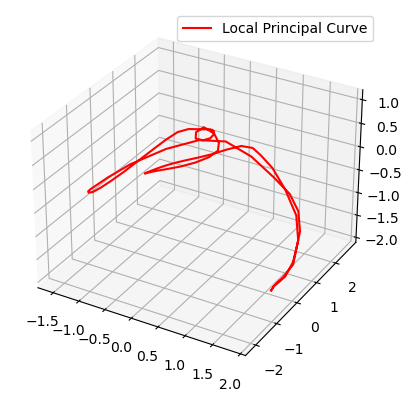

In [79]:
#     # Fit the Local Principal Curve on the subset
# lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=2)
# paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint], remove_similar_end_start_points=True)

# # Extract the first path (assuming one main path)
spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)


path=paths[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pert_3d_subset[:,0], pert_3d_subset[:,1], pert_3d_subset[:,2], alpha=0.5, label='Data')
ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
ax.legend()
plt.show()


In [76]:
    # Calculate early time point
avg_early_timepoint = pert_df[(pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)][["PCA_1", "PCA_2", "PCA_3"]].mean().values

In [64]:
    # Calculate early time point
    avg_late_timepoint = pert_df[
        (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].max())-10 |
        (pert_df["predicted_stage_hpf"] <= pert_df["predicted_stage_hpf"].max())
    ][["PCA_1", "PCA_2", "PCA_3"]].mean().values
avg_late_timepoint

array([-0.38931624, -0.2802845 , -0.02990364])

In [74]:
avg_late_timepoint = pert_df[(pert_df["predicted_stage_hpf"] >= (pert_df["predicted_stage_hpf"].max() -3))][["PCA_1", "PCA_2", "PCA_3"]].mean().values
avg_late_timepoint

array([-1.00805304,  2.00500868, -0.52024106])

(array([ 391.,  528., 2132., 1667., 1301.,  773.,  337.,  289.,  176.,
         164.]),
 array([12.03685388, 18.06084102, 24.08482816, 30.1088153 , 36.13280244,
        42.15678958, 48.18077672, 54.20476386, 60.228751  , 66.25273814,
        72.27672528]),
 <BarContainer object of 10 artists>)

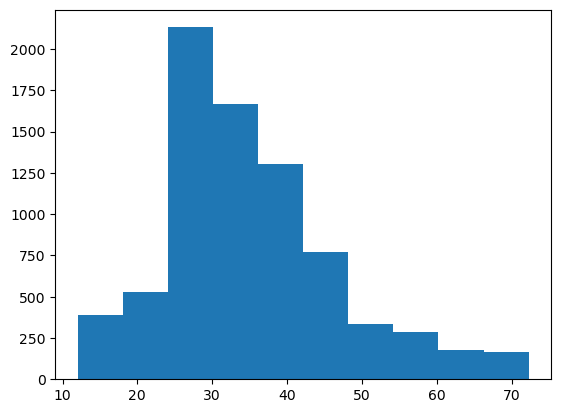

In [67]:
plt.hist(pert_df["predicted_stage_hpf"])

In [92]:

# Create a 3D scatter plot for the data points
fig = go.Figure(data=[go.Scatter3d(
    x=pert_3d_subset[:, 0], 
    y=pert_3d_subset[:, 1], 
    z=pert_3d_subset[:, 2],
    mode='markers',
    marker=dict(size=2, opacity=0.5),
    name='Data'
)])

# Add the Local Principal Curve as a line plot
fig.add_trace(go.Scatter3d(
    x=[avg_late_timepoint[ 0]], 
    y=[avg_late_timepoint[ 1]], 
    z=[avg_late_timepoint[ 2]],
    mode='markers',
    marker=dict(size= 10, color="black"),
    name='Local Principal Curve'
))

fig.add_trace(go.Scatter3d(
    x=[avg_early_timepoint[ 0]], 
    y=[avg_early_timepoint[ 1]], 
    z=[avg_early_timepoint[ 2]],
    mode='markers',
    marker=dict(size= 10, color="red"),
    name='Local Principal Curve'
))


fig.add_trace(go.Scatter3d(
    x=path[:, 0], 
    y=path[:, 1], 
    z=path[:, 2],
    mode='lines',
    line=dict(color='red', width=2),
    name='Local Principal Curve'
))

# Update plot layout
fig.update_layout(
    title='3D Scatter Plot with Local Principal Curve',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    legend_title='Legend'
)

fig.show()

In [77]:

# Create a 3D scatter plot for the data points
fig = go.Figure(data=[go.Scatter3d(
    x=pert_3d_subset[:, 0], 
    y=pert_3d_subset[:, 1], 
    z=pert_3d_subset[:, 2],
    mode='markers',
    marker=dict(size=2, opacity=0.5),
    name='Data'
)])

# Add the Local Principal Curve as a line plot
fig.add_trace(go.Scatter3d(
    x=[avg_late_timepoint[ 0]], 
    y=[avg_late_timepoint[ 1]], 
    z=[avg_late_timepoint[ 2]],
    mode='markers',
    marker=dict(size= 10, color="black"),
    name='Local Principal Curve'
))

fig.add_trace(go.Scatter3d(
    x=[avg_early_timepoint[ 0]], 
    y=[avg_early_timepoint[ 1]], 
    z=[avg_early_timepoint[ 2]],
    mode='markers',
    marker=dict(size= 10, color="red"),
    name='Local Principal Curve'
))


fig.add_trace(go.Scatter3d(
    x=path[:, 0], 
    y=path[:, 1], 
    z=path[:, 2],
    mode='lines',
    line=dict(color='red', width=2),
    name='Local Principal Curve'
))

# Update plot layout
fig.update_layout(
    title='3D Scatter Plot with Local Principal Curve',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    legend_title='Legend'
)

fig.write_html(os.path.join(model_results_path,f"test_spline_{pert}.html"))

In [12]:
merged_df["beta_log10"] = np.log10(merged_df["beta"])

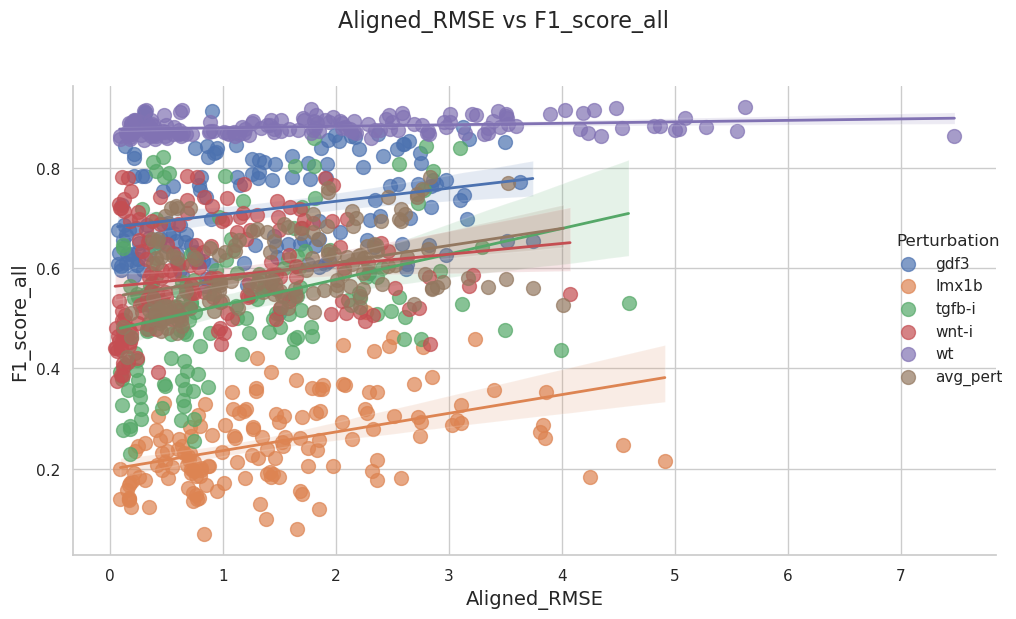

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define variables for x and y
x_variable = "Aligned_RMSE"
y_variable = "F1_score_all"

# Dynamically generate the title
plot_title = f"{x_variable} vs {y_variable}"

# Create the scatter plot with trend lines
scatter_plot = sns.lmplot(
    data=merged_df,
    x=x_variable,
    y=y_variable,
    hue='Perturbation',
    scatter_kws={'s': 100, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend lines
    height=6,  # Height of the plot
    aspect=1.5  # Aspect ratio
)

# Add dynamic title and labels
scatter_plot.fig.suptitle(plot_title, fontsize=16, y=1.03)
scatter_plot.set_axis_labels(x_variable, y_variable, fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

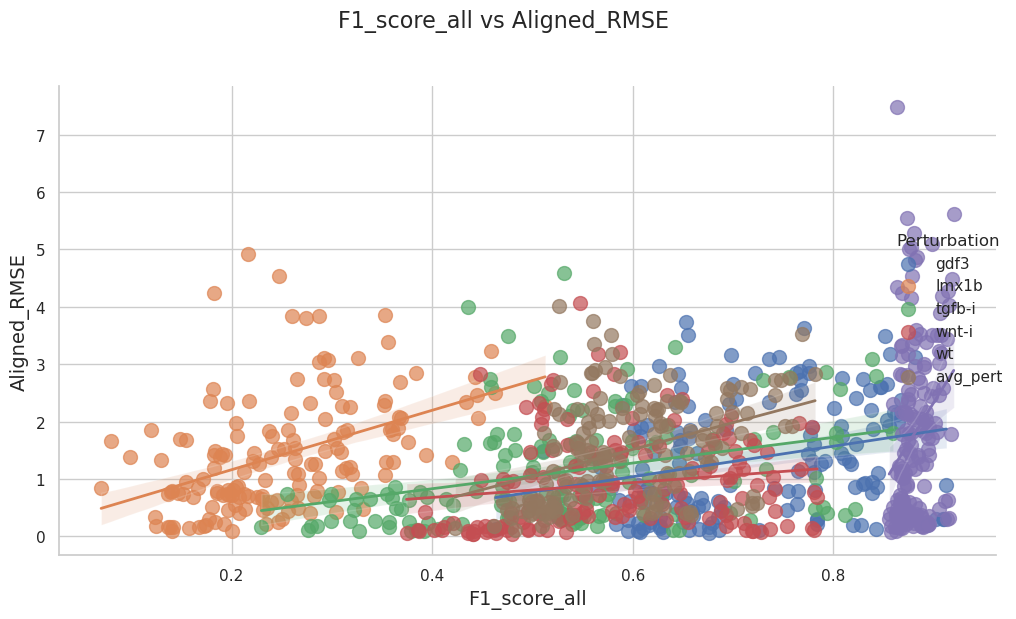

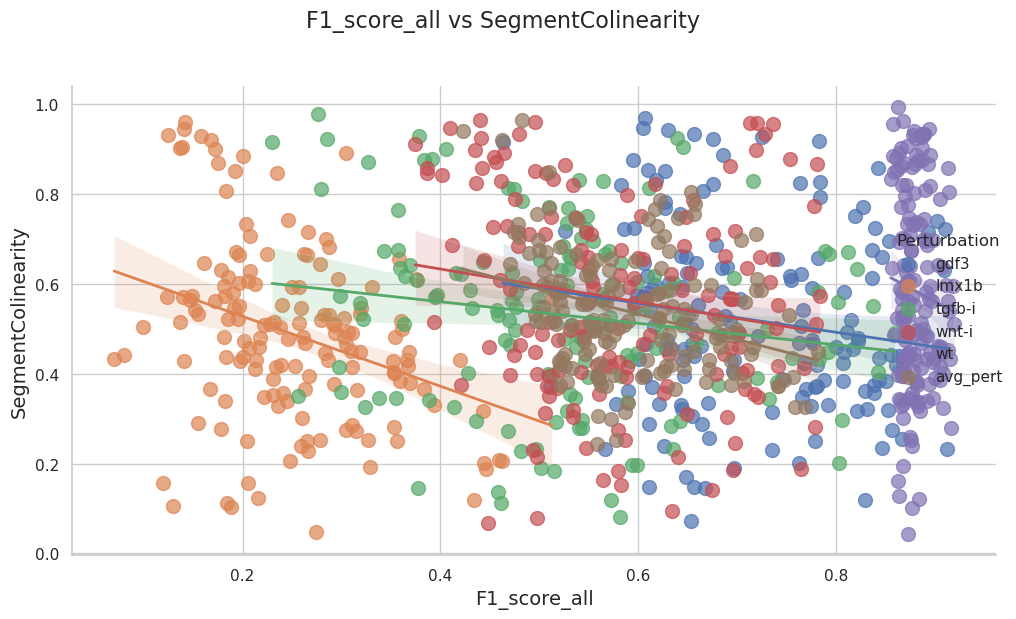

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define variables for x and y
y_variable = "Aligned_RMSE"
x_variable = "F1_score_all"

# Dynamically generate the title
plot_title = f"{x_variable} vs {y_variable}"

# Create the scatter plot with trend lines
scatter_plot = sns.lmplot(
    data=merged_df,
    x=x_variable,
    y=y_variable,
    hue='Perturbation',
    scatter_kws={'s': 100, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend lines
    height=6,  # Height of the plot
    aspect=1.5  # Aspect ratio
)

# Add dynamic title and labels
scatter_plot.fig.suptitle(plot_title, fontsize=16, y=1.03)
scatter_plot.set_axis_labels(x_variable, y_variable, fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define variables for x and y
y_variable = "SegmentColinearity"
x_variable = "F1_score_all"

# Dynamically generate the title
plot_title = f"{x_variable} vs {y_variable}"

# Create the scatter plot with trend lines
scatter_plot = sns.lmplot(
    data=merged_df,
    x=x_variable,
    y=y_variable,
    hue='Perturbation',
    scatter_kws={'s': 100, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend lines
    height=6,  # Height of the plot
    aspect=1.5  # Aspect ratio
)

# Add dynamic title and labels
scatter_plot.fig.suptitle(plot_title, fontsize=16, y=1.03)
scatter_plot.set_axis_labels(x_variable, y_variable, fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

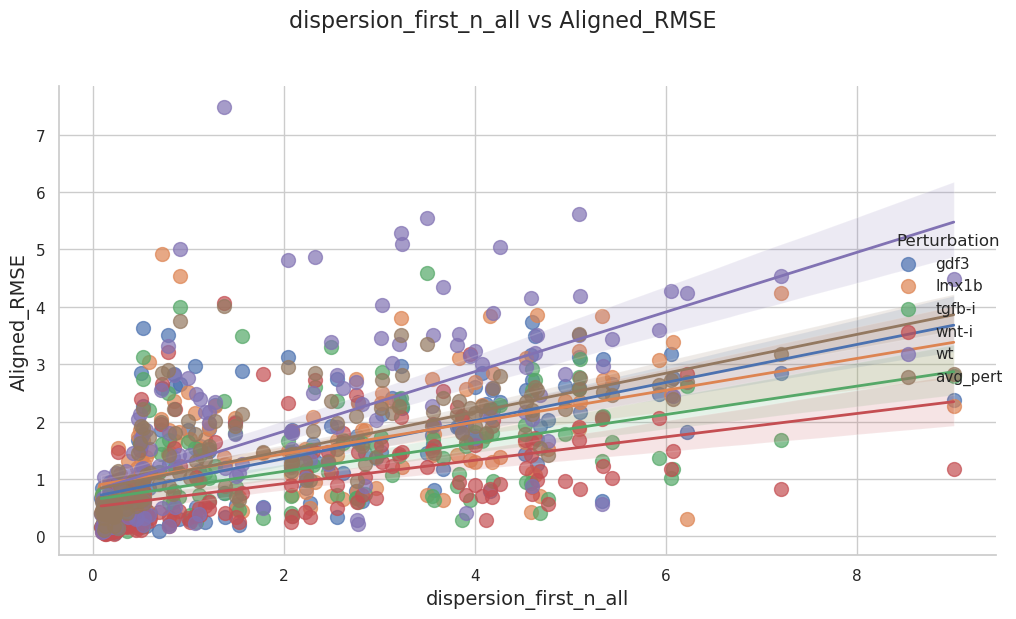

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define variables for x and y
y_variable = "Aligned_RMSE"
x_variable = "dispersion_first_n_all"

# Dynamically generate the title
plot_title = f"{x_variable} vs {y_variable}"

# Create the scatter plot with trend lines
scatter_plot = sns.lmplot(
    data=merged_df,
    x=x_variable,
    y=y_variable,
    hue='Perturbation',
    scatter_kws={'s': 100, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend lines
    height=6,  # Height of the plot
    aspect=1.5  # Aspect ratio
)

# Add dynamic title and labels
scatter_plot.fig.suptitle(plot_title, fontsize=16, y=1.03)
scatter_plot.set_axis_labels(x_variable, y_variable, fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define variables for x and y
y_variable = "Aligned_RMSE"
x_variable = "dispersion_first_n_all"

# Dynamically generate the title
plot_title = f"{x_variable} vs {y_variable}"

# Create the scatter plot with trend lines
scatter_plot = sns.lmplot(
    data=merged_df,
    x=x_variable,
    y=y_variable,
    hue='Perturbation',
    scatter_kws={'s': 100, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend lines
    height=6,  # Height of the plot
    aspect=1.5  # Aspect ratio
)

# Add dynamic title and labels
scatter_plot.fig.suptitle(plot_title, fontsize=16, y=1.03)
scatter_plot.set_axis_labels(x_variable, y_variable, fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

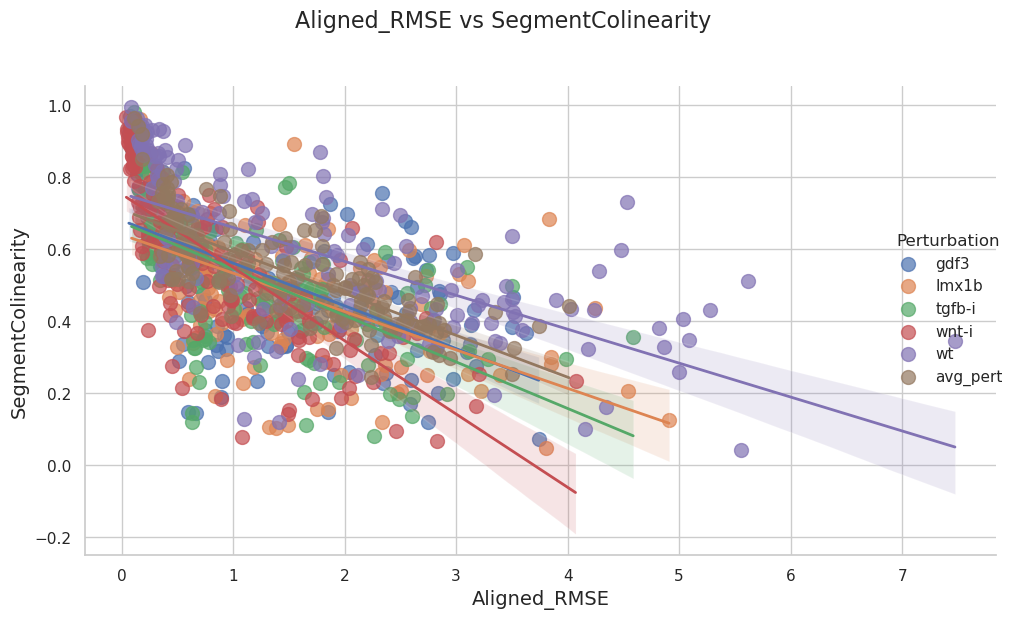

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define variables for x and y
x_variable = "Aligned_RMSE"
y_variable = "SegmentColinearity"

# Dynamically generate the title
plot_title = f"{x_variable} vs {y_variable}"

# Create the scatter plot with trend lines
scatter_plot = sns.lmplot(
    data=merged_df,
    x=x_variable,
    y=y_variable,
    hue='Perturbation',
    scatter_kws={'s': 100, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend lines
    height=6,  # Height of the plot
    aspect=1.5  # Aspect ratio
)

# Add dynamic title and labels
scatter_plot.fig.suptitle(plot_title, fontsize=16, y=1.03)
scatter_plot.set_axis_labels(x_variable, y_variable, fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()